# Risk score learning for COVID-19 contact tracing apps

Zixi (Chelsea) Chen, Zihe Zhang, Marcel Torne Villasevil

This notebook is based on the Risk score learning for COVID-19 contact tracing apps (2021) paper by Murphy et.al.

In [ ]:
import numpy as np
import scipy
import scipy.stats
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

We have created a helper file to store all the helper functions we have defined to set up, train, and evaluate the models.

In [ ]:
from helpers import *

## Problem Statement

The authors sought to build a model for estimating the risk a user was infected during a particular COVID exposure event, using features collected by digital contact apps. Specifically, they wanted to build a model that can automatically learn parameters from (simulated) data.

## Context & Scope

Combatting COVID, a global pandemic since early 2020, is an important task for humans. One of the tried-and-true approaches to combat a pandemic is quarantine, which essentially isolates infectious individuals from healthy people until they are not infectious anymore. Proactive quarantine, which further identifies people that have a high likelihood of getting the disease due to recent exposures to the virus and isolates them, will help further constrain the COVID transmission. In order to do effective proactive quarantine, one needs to be able to do contact tracing. Contact tracing apps for COVID based on smartphones have been developed. One of the next critical steps is to be able to assess a user’s risk, or the necessity of proactive quarantine, based on the contact tracing history, objectively and automatically. This paper investigated the performance of such a model for exposure risk assessment by simulating many real life scenarios that could make the model inferencing challanging.

## Existing Work

As early as in May, 2020, in the paper “Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing”, researchers proposed that using digital contact-tracing apps can effectively combat the COVID pandemic. These apps work by pushing notifications of potentially high-risk exposure events through measuring proximity among phones and health conditions of app users. In fact, the core of a digital contact tracing app is just a risk score model, which is capable of estimating the probability of infection and thus deciding whether or not to notify the users and recommend taking precautions.

According to “Using real-world contact networks to quantify the effectiveness of digital contact tracing and isolation strategies for Covid-19 pandemic” and other papers, with generated data under simulated conditions, contact tracing systems coupled with quarantine of notified contacts can effectively mitigate the spread of disease. Moreover, many studies even demonstrate that such technology is also effective under real-world circumstances. For instance, in the paper “The epidemiological impact of the NHS COVID-19 app”, researchers provide real data that the NHS COVID-19 app was able to avert about 284000 to 594000 COVID infections and about 4200-8700 deaths.

The SWISS model mentioned in the paper is also one example of an EN-based contact tracing app, of which the risk model has parameters manually selected.


## Contribution

As many papers focus on simulating the advantages of using digital contact tracing apps, most of them assume that the risk score model is known. The COVID risk score models contain many parameters, and in a lot of papers these parameters are determined by domain experts in the field of public health. However, this paper would like to show an alternative data-driven approach, through which machine learning models can automatically learn the parameters from the data. Moreover, the design in this paper also incorporates not only the proximity but also contagiousness of index cases to estimate the risk. 

The researchers aim to show the power and robustness of such an approach outperforming the manual baseline design. They also explicitly make comparisons between their model, which learns parameters from data, and the SWISS model, which has a manual configuration based on AUC scores.


## Technical Content (High Level)

The data simulator generates hazard scores based on exposure duration, distance between users during exposure, and the time since the onset of symptoms of the case at the time of exposure. Infection probabilities can then be computed using these risk scores

The risk score model used by Google/Apple depends on exposure duration, bluetooth attenuation, and quantized symptom onset time. It uses attenuation as an accessible alternative of distance during exposure, and quantized symptom onset time as an accessible alternative of infectiousness based on non-quantized symptom onset time.

The GAEN risk score model makes piecewise constant approximation to risk-vs-attenuation and map symptom onset values to discrete infectiousness levels using a lookup table, leaving 10 parameters of the risk score model for ML to learn: 1 scaling factor, 4 attenuation weights with 3 attenuation thresholds, and 2 infection weights. The parameters are optimized by gradient descent minimizing the binary cross entropy.


## Technical Content (Details)


### Model Setup

As mentioned above, the paper uses a simple probabilisitc model for COVID-19 transmission, and this model is also used to simulate data. 

The risk score or the hazard score is calculated from the exposure duration in minutes, the distance between people during the exposure, and the time since the onset of symptoms of the case at the time of the exposure. In the single exposure case, the score for each of the $N$ exposure events and thus for each of the $N$ users is defined as follow:

$$s_n = f_{\text{hazard}}(\tau_n, d_n, \sigma_n) = \tau_n \times f_{\text{dist}}(d_n) \times f_{\text{inf}}(\sigma_n), \\ s_n = \text{risk score}, \ \tau_n = \text{exposure duration}, \ d_n = \text{distance during exposure}, \ \sigma_n = \text{time since symtom onset}$$

Then, the risk score can be converted into its respective probability of infection by using a standard expojnential dose response model like below:

$$p_n = \mathbf{P}(y_n = 1 | x_n) = 1 - e^{-\lambda s_n}, \\ \lambda = \text{a fixed constant matching empirical attack rate} = 3.1 \times 10^{-6}$$


The risk score model the GAEN app is using is similar. However, note that the app does not observe distance directly, so it uses bluetooth attenuation as an alterantive of distance. 

Moreover, the model makes a piecewise constant approximation to attenuation, i.e. it uses a piece wise function $f_{\text{ble}}(a_n)$ to approximate tthe continuous function $f_{\text{dist}}(d_n)$, so the whole real line is partitioned into 4 intervals with 3 weights. A higher attenuation means a smaller distance and thus a higher weight, since the weight is used as a sub-risk-score given attenuation. The mathematic formula is shown below:

\begin{aligned}
f_{\text{ble}}(a_n) = 
  \begin{cases} 
      w_1^{\text{ble}} & a_n \leq \theta_1^{\text{ble}} \\
      w_2^{\text{ble}} &  \theta_1^{\text{ble}} < a_n \leq \theta_2^{\text{ble}} \\
      w_3^{\text{ble}} & \theta_2^{\text{ble}} < a_n \leq \theta_3^{\text{ble}}  \\
      w_4^{\text{ble}} & \theta_3^{\text{ble}} > a_n
  \end{cases}
\end{aligned}


Besides, the data for days since symptom onset is a sensitive attribute. To ensure privacy, the values are mapped into one of 3 infectiousness level, and each level has a corresponding weight like below:

\begin{aligned}
c_n = 
  \begin{cases} 
      1 & \sigma_n \leq -5 \text{  or  } \sigma_n > 10 \\
      2 &  -5 < \sigma_n \leq -2 \text{  or  } 6 < \sigma_n \leq 10 \\
      3 & -2 < \sigma_n \leq 6
  \end{cases}, \quad 
f_{\text{con}}(c_n) = 
  \begin{cases} 
      0 & c_n = 1 \\
      w_2^{\text{con}} &  c_n = 2 \\
      w_3^{\text{con}} & c_n = 3
  \end{cases}
\end{aligned}

Thus, this leaves 10 parameters of the risk model for machine learning to optimize:

$$\phi = [\mu, w_1^{\text{ble}}, w_2^{\text{ble}}, w_3^{\text{ble}}, w_4^{\text{ble}}, \theta_1^{\text{ble}}, \theta_2^{\text{ble}}, \theta_3^{\text{ble}}, w_2^{\text{con}}, w_3^{\text{con}}]$$

So now the estimated risk score $r_n$ and the estimated infection probability $q_n$ are

$$r_n = f_{\text{risk}}(\tau_n, a_n, c_n | \phi) = \tau_n \times f_{\text{ble}}(a_n | \phi) \times f_{\text{con}}(c_n | \phi), \\
q_n = 1 - e^{-\mu r_n} = 1 - e^{-\mu f_{\text{risk}}(\tau_n, a_n, c_n | \phi)}.$$



### Optimization and tricks

In this paper, they generate an infection label $Y_j$ for each user (for each exposure in the case of single exposure). 

They optimize the parameters by minimizing the binary cross entropy across all $N$ users corresponding to the $N$ exposure events

$$L(\phi) = - \sum_{n=1}^N Y_n \log(q_n) + (1-Y_n) \log(1-q_n).$$

There are a few tricks used in optimization.

**Monotonocity: Reparametrization & Projection**

To make sure that the risk score is monotonically increasing in attenuation, i.e. $w_1^{\text{ble}} < w_2^{\text{ble}} < w_3^{\text{ble}} < w_4^{\text{ble}}$, the parameters are reparametrized to its residual form $$(w_1^{\text{ble}}, w_2^{\text{ble}} = w_1^{\text{ble}} + \Delta_2^{\text{ble}}, w_3^{\text{ble}} = w_2^{\text{ble}} + \Delta_3^{\text{ble}}, w_4^{\text{ble}} = w_3^{\text{ble}} + \Delta_4^{\text{ble}}),$$ so gradient descent actually optimizes over $(w_1^{\text{ble}}, \Delta_2^{\text{ble}}, \Delta_3^{\text{ble}}, \Delta_4^{\text{ble}})$, with projection used in process to make sure the residuals $\Delta_2^{\text{ble}}, \Delta_3^{\text{ble}}, \Delta_4^{\text{ble}} > 0$.

**Differentiablity: Soft Thresholding & Temperature Elevating**

With approximation, attenuation is partitioned to discrete buckets, but the loss function is not differentiable with respect to the bucket thresholds $\theta_1^{\text{ble}}, \theta_2^{\text{ble}}, \theta_3^{\text{ble}}$. Thus, with the use of sigmoid function $\sigma_t(x) = \frac{1}{1+e^{-tx}}$ with a temperature of $t$, the hard binning can be replaced with soft binning to ensure differentiability. Now, exposure duration is no longer restricted to one bucket, and the duration $\tau_{nb}$ in each bucket $b$ is defined below:

$$\tau_{nb} = \tau_{n} \ \sigma_t(a_n - \theta_{b-1}^{\text{ble}}) \ \sigma_t(\theta_{b}^{\text{ble}} - a_n).$$

With this change, the estimated risk score becomes

$$r_n = \left[\sum_{b=1}^4 \tau_{nb} w_b^{\text{ble}}\right] \times f_{\text{con}}(c_n).$$

Note that when the temperature $t$ is small, the soft binning can be very different from hard binning. Thus, during gradient descent, temperature is gradually increased from a small value to larger values, so that soft thresholds will approximate better the hard thresholds as used by the GAEN app.

**Gradient Descent Scale: Two-Step Optimization**

Note that the parameters can have very different scales. The thresholds $\theta_1^{\text{ble}}, \theta_2^{\text{ble}}, \theta_3^{\text{ble}}$ have larger ranges and scales than the weight parameters. Consequently, using the same learning rate for updates in gradient descent can be problematic. If the learning rate is small, it might work well for the weights, but it could be too small for the threshold parameters to converge; on the other hand, if the learning rate is larger, it might work well for the tresholds, but it could also overshoot the weight parameters.

The paper does not explicitly talk about this problem, but according to its coded functions, a two-step optimization is employed. The method applies a larger learning rate to the thresholds and a smaller learning rate to the weights separately to improve the gradient descent performance.

**Speed & Stability: Decaying Learning Rate**

The coded functions of this paper also use decaying learning rate for gradient descent. This is good theoretically, since a large initial learning rate might boost the training, and a gradually decreasing learning rate might help gradient descent to converge to local minima avoiding oscillation.


 


### More Complex Cases

**Micro Exposure**

The model is extended to handle micro-exposures in every exposure event. Just like in the single exposure case, soft thresholding is also performed for easier optimization. In this case with $K_n$ being the number of micro-exposures for each exposure event, the duration $\tau_{nb}$ in each bucket $b$ becomes:

$$\tau_{nb} = \sum_{k=1}^{K_n} \tau_{nk} \ \sigma_t(a_{nk} - \theta_{b-1}^{\text{ble}}) \ \sigma_t(\theta_{b}^{\text{ble}} - a_{nk}).$$

Then, like before, each of the $N$ exposure has an estimated risk score of

$$r_n = \left[\sum_{b=1}^4 \tau_{nb} w_b^{\text{ble}}\right] \times f_{\text{con}}(c_n).$$


**Multiple Exposure**

The model is also extended to the case where one user can have multiple exposures, with the assumption that exposures are independent to each other. Thus, for each of the $J$ users who has experienced exposure events in $E_j$, the infecetion probability $P_j$ based on the simulator is

$$P_j = 1-(1-p_0) \prod_{n \in E_j} (1-p_n), $$

with $p_0$ being the prior probability of an exposure for the user.

Similarly, the risk score $R_j$ and the infection probability $Q_j$ for each of the $J$ users estimated by the app becomes 

$$R_j = \sum_{n \in E_j} r_n, \quad Q_j = 1 - e^{-\mu R_j}.$$

As a result, the new binary cross entropy to minimize is now 

$$L(\phi) = -\sum_{j=1}^J Y_j \log Q_j + (1-Y_j) \log(1-Q_j).$$


**Censoring**

To simulate a real life scenario that users may get expoused to events that are not recorded by their phone, the authors used a cencoring proceduce on the training data. After the exposure events were generated, each positive exposure events had a probability, parameterized by $p_u$, to be censered as a negative events, which was then passed into the training set. The paper investigated how the level of censoring would affect the model performance.

**Bagging**

To generate training samples that contain multiple exposures, such that one training sample will contain a bag of k exposure events and a label y, they used a hierachical sampling procedure, "bagging". After generating a "pool" of exposure events from a 3-dimensional grid based on exposure duration ($\tau$), distance between users during exposure ($d$), and the time since the onset of symptoms of the case at the time of exposure ($\sigma$).  They first sample the value k from a truncated negative binomial distribution. This allowed they to make sure the bag size k was kept at a maximum number. Then each bag was assigned to be either a positive or a negative bag. Each positive bag was further assigned to either have exactly 1 positive exposure event or have N positive exposure events where N was sampled uniformaly from {1,2,3}. Finally, each bag, depending on the number of negative and positive exposure events in the bag, would draw the respective numbers of positive and nagetive events from the "pool".

# Experiments 

First of all, the experiments run in the paper were performed using an artificial dataset made from a simulation. The authors do not have access to the real data since due to privacy concerns the data is not collected. Remember that the data simulated represents interactions between several parties and describe this interactions with time, distance and days since symptom onset terms.

The authors would like to prove three different claims by performing their experiments. First, they would like to prove that their model outperforms the Swiss baseline and that the model performance is upper bounded by the oracle model. Looking at their experiments, we clearly see that their model performs better than the Swiss baseline in all cases and it is also upper bounded by the oracle model. The fact that their model is upper bounded by the oracle model is shown in their experiments, and also does make sense since this model has additional information that is not available to the trained model. However, even though we see that their model does perform better than the Swiss baseline, the Swiss baseline does take into account the infectiousness of the index case. Hence, we feel it might not be a fair comparison since it could be that in real life it is not possible to take this into account and hence the trained model would be invalid. Furthermore, the Swiss model was trained on real data in comparison to the trained model, hence, we doubt that maybe the simulated data si wrong and which could explain why the Swiss model is doing worse.  However, all of these are just hypothesis and what we want to say that it is hard to make such claim with the information and the research given.

Moreover, the authors also want to prove that with more noise in the simulated data, it is much harder for the model to make accurate predictions. So they want to see which are the settings that make the learning more difficult. They show that with a higher censoring probability which means that there will be on average more censoring, the accuracy of the model greatly diminishes. Moreover, they also show that when they increase the bag size, meaning, the group of exposures that has its associated label, then in general the accuracy again decreases when there is a single exposure. They don’t explain it but it does make sense since it will be harder for the model to know which one of the many exposures was the correct one, this gets harder with the number of exposures in a bag increasing. However, if they have a max number of positive events per bag of 3, then the accuracy actually increases until 4, and they explain this happens because the learning algorithm gets more signal to identify positive bags. However, similarly as before, this signal fades as the bag size increases beyond 4. All of these results are supported by their experiments but also with some mathematical intuition which according to us allows them to prove their claims. 

Finally, they perform a small test of robustness to model mismatch. Since, the simulator is most likely not accurate of how COVID-19 is transmitted. Then they want to study how good or bad would this model do in real life. They see that the model actually does worse but when the simulator is more incorrect but it is still better than the Swiss model. The way they simulate that their simulator is incorrect is by truncating the exponent in the probability of infection given an event. It is indeed a valid way to add some noise into the model however, we do not think that this actually englobes all possible ways the model could be wrong and since there is no proof behind we also feel it is hard to claim that their statement has been claimed. At the end of the day, we believe that the claim they wanted to support through this experiment was to show that even if their simulation was wrong, their model would still be better than the Swiss model. In our opinion, this experiment is not robust enough to make this claim



# Evaluation

We believe the work is indeed technically sound, there was a lot of work put into trying to simulate as closely as possible the propagation of the COVID-19 virus together with many mathematical techniques to make the simulated data as close as possible to reality. However, as we explained in the experiment section, we believe that the claims regarding the robustness of the model, even if the simulated data is not completely accurate, is not sufficient enough to use this model in real life. However, we do believe that if this model could be trained on real data then it is possible that it would be good enough to use on real data. 
Moreover, if the model worked, it would indeed  practical to use this model in real data since this does not take too long to learn, in less than 5 minutes you could have a model learned from a dataset of the size of the simulated dataset presented in the paper (around 33600 data points).
Furthermore, we believe it would be interesting to apply newer techniques to this simulated dataset and observe whether it performs better or worse than the current one. For example, as they mention in the paper, it would be interesting to compare this model with some Neural Network model or Gaussian Process.
Nevertheless, the upside of this model is that it is very interpretable, the model has built-in some prior knowledge on how viruses spread. Which does make it interpretable since we know the meaning of all the variables that are being used for this optimization. This is much harder if we used Neural Networks since the interpretability of this model is very complicated. Hence, we observe there is a trade-off between a more interpretable model (the one in the paper) and a model that would probably perform better (NNs).


# Future work

There are some aspects and questions that we believe could be explored further.  More concretely, one of the things that most interests us is regarding the section of “Robustness  to model mismatch” from the paper where the authors try to prove that even if the simulator is wrong, the model will still perform well. However, we believe there are flaws in their experiment. They simulate this model mismatch by instead of using an exponential function to compute the probability given the risk score, they use a Taylor series expansion truncated to a finite number of terms. We believe that this is most likely not enough, meaning that this does not bring enough error into the simulator. Hence, we believe there is further work to do here since the negative impact that this can have if it is deployed in real life and if the simulator was indeed very off, could be very bad.

Furthermore, we are also curious to study how does the error in the bluetooth signal propagate into the model’s decisions. In the paper, the authors suppose there is no error, however, they mention that this is not the case and that it should be studied. Again, we believe the problems can be big if deployed in real life and depending on the robustness of the model.

It will also be important to test the model on real data to see if the conclusions in this paper still holds. One caveats of using only simulated data is that we would not know if we are sampling from the correct/real distribution of exposure events.

Finally, there is one final term in the equation to compute the probability which is the prior infection rate p_0. This one cannot be inferred and it would be interesting to see also how this can affect the model predictions.


# Broader Impact

Even though we know that contact-tracing apps can be highly capable of controlling the spread of COVID-19, there comes a lot of questions: for instance, as launching such an application needs continuous collection of data from individuals, could privacy become an issue? To protect users’ privacy, Apple and Google use a decentralized system, and some governments also have pledged to protect data privacy. However, some still worry about who has access to the data, whether the data will be used for other purposes, and when the data will be deleted.

Moreover, should the use of tracking apps be compulsory or voluntary? This is highly related to how much responsibility for public health every individual is taking. In some countries, using a contact-tracing system is required. For instance, in China, each person has a QR code on the app, and the QR code shows whether or not one individual has COVID or has a high risk of getting COVID. One has to show a valid QR code in order to get into public spaces like shopping malls or use public transportations. It turns out that such a large-scale adoption is effective and efficient in breaking the transmission chain of the disease; however, some may argue that individual freedom is restricted and somehow privacy is not valued enough, and the country-wise use of the app can be unfriendly to those who are not familiar with or have limited access to this technology. On the other hand, when the use of tracking apps is voluntary, the data would be less complete and consequently the power of the apps in combating COVID could be much weaker.

Besides, the learning approach proposed in this paper aims to estimate the parameters used in a risk score model by doing gradient descent on binary cross entropy. However, if the model specification is not appropriate, or the training does not converge to find a good-enough set of parameters, the model could make wrong predictions working on real-world data. The model could cause unjustified panic if it makes false positive predictions, and it could increase infection risks when making false negative predictions, since users who rely on the app might experience a false sense of safety and take social distancing less seriously. 


# Implementation and Experiments

We will start by implementing the approximate model and we will run some experiments to analyze its performance. In this model, the parameters that have to be learned are the following:

$$[\mu, w_1^{ble}, w_2^{ble}, w_3^{ble}, w_4^{ble}, \theta_1^{ble}, \theta_2^{ble}, \theta_3^{ble}, w_2^{con}, w_3^{con}]$$

In [ ]:
# GLOBAL VARIABLES
idx_scaling_factor = 0
idx_ble_weights, num_ble_weights = 1, 4
idx_ble_thresholds, num_ble_thresholds = 1+4, 3
idx_con_weights, num_con_weights = 1+4+3, 2
global_temperature = 1

true_params = np.array([0.285311,0.384, 0.151, 0.017, 0.008, 55, 8, 5, 0.6, 2.0]) 

In [ ]:
# SUB RISK SCORE FOR DAYS SINCE SYMPTOM ONSET BY USING INFECTIOUSNESS
def f_con(params, x_n):
    '''
    Input:
        params - [mu (1), attenuation weights (4), attenuation threshold in residual form (3), infectiousness weights (2)]
        x_n - (tau_n, a_n, c_n)
              tau_n - exposure duration for all k micro exposures in one exposure
              a_n - bluetooth attenuation during exposure (alternative of distance during exposure)
              c_n - infectiousness level (alternative of time since COVID symptom onset)
    Output: 
        an approximation of simulated risk given time since COVID symptom onset using infectiousness
    '''
    c_n = x_n[:,2] 
    weight_con = params[idx_con_weights:]  # params[(1+4+3):]  

    res = torch.zeros_like(c_n)
    res[c_n == 2] = weight_con[0]
    res[c_n == 3] = weight_con[1]

    return res


# SUB RISK SCORE FOR DISTANCE BY USING BLUETOOTH ATTENUATION
def f_ble(params, x_n):
    '''
    Input:
        params - [mu (1), attenuation weights (4), attenuation threshold in residual form (3), infectiousness weights (2)]
        x_n - (tau_n, a_n, c_n)
              tau_n - exposure duration # for all k micro exposures in one exposure (not considering micro exposures for now)
              a_n - bluetooth attenuation during exposure (alternative of distance during exposure)
              c_n - infectiousness level (alternative of time since COVID symptom onset)
    Output:
        an approximation of simulated risk given distance using bluetooth attenuation
    '''
    a_n = x_n[:,1]
    res = torch.zeros_like(a_n)

    threshold_ble = params[idx_ble_thresholds:(idx_ble_thresholds+num_ble_thresholds)]  # params[(1+4):(1+4+3)]
    threshold_ble_abs = [threshold_ble[0], sum(threshold_ble[0:2]), sum(threshold_ble[0:3])]  # residual parameters to scoring parameters
    weight_ble = params[idx_ble_weights:(idx_ble_weights+num_ble_weights)]  # params[1:(1+4)]

    res[a_n <= threshold_ble_abs[0]] = weight_ble[0]
    res[torch.logical_and(a_n > threshold_ble_abs[0] , a_n <= threshold_ble_abs[1])] = weight_ble[1]
    res[torch.logical_and(a_n > threshold_ble_abs[1] , a_n <= threshold_ble_abs[2])] = weight_ble[2]
    res[a_n > threshold_ble_abs[2]] = weight_ble[3]

    return res


In [ ]:
# SIGMOID FUNCTION
sigmoid = lambda x, temp: 1 / (1 + torch.exp(-temp*x))


# WEIGHTS FOR EACH BLUETOOTH ATTENUATION WEIGHTS USING SOFT BINNING
def tau_nb(params, x_n, b, temp):
    '''
    Input: 
        params - [mu (1), attenuation weights (4), attenuation threshold in residual form (3), infectiousness weights (2)]
        x_n - (tau_n, a_n, c_n)
              tau_n - exposure duration for all k micro exposures in one exposure
              a_n - bluetooth attenuation during exposure (alternative of distance during exposure)
              c_n - infectiousness level (alternative of time since COVID symptom onset)
        b - the bucket, should be one of 0 or 1 or 2 or 3
        temp - temperature for sigmoid
    Output:
        the soft weights for each bucket to use for a user
    '''
    tau_n, a_n, c_n = x_n[:, 0], x_n[:, 1], x_n[:, 2]
    threshold_ble = params[idx_ble_thresholds:(idx_ble_thresholds+num_ble_thresholds)]
    threshold_ble_abs = [threshold_ble[0], sum(threshold_ble[0:2]), sum(threshold_ble[0:3])]  # residual parameters to scoring parameters
    
    if b == 0:
        soft_dur = tau_n * 1 * sigmoid(threshold_ble_abs[b]-a_n, temp)
    elif b == 3:
        soft_dur = tau_n * sigmoid(a_n-threshold_ble_abs[b-1], temp) * 1
    else:
        soft_dur = tau_n * sigmoid(a_n-threshold_ble_abs[b-1], temp) * sigmoid(threshold_ble_abs[b]-a_n, temp)

    return soft_dur


# RISK SCORE USING HARD BINNING
def r_n_hard(params, x_n):
    '''
    Input:
        params - [mu (1), attenuation weights (4), attenuation threshold in residual form (3), infectiousness weights (2)]
        x_n - (tau_n, a_n, c_n)
              tau_n - exposure duration for all k micro exposures in one exposure
              a_n - bluetooth attenuation during exposure (alternative of distance during exposure)
              c_n - infectiousness level (alternative of time since COVID symptom onset)
        temp - temperature for sigmoid
    Output:
        an approximation of harzard score for exposure using hard binning
    '''
    tau_n, a_n, c_n = x_n[:,0], x_n[:,1], x_n[:,2]
    score = torch.zeros_like(a_n)

    score += tau_n
    score *= f_ble(params, x_n)
    score *= f_con(params, x_n)

    return score


# RISK SCORE USING SOFT BINNING
def r_n_soft(params, x_n, temp):
    '''
    Input:
        params - [mu (1), attenuation weights (4), attenuation threshold in residual form (3), infectiousness weights (2)]
        x_n - (tau_n, a_n, c_n)
              tau_n - exposure duration for all k micro exposures in one exposure
              a_n - bluetooth attenuation during exposure (alternative of distance during exposure)
              c_n - infectiousness level (alternative of time since COVID symptom onset)
        temp - temperature for sigmoid
    Output:
        an approximation of harzard score for exposure using soft binning
    '''
    tau_n, a_n, c_n = x_n[:,0], x_n[:,1], x_n[:,2]
    score = torch.zeros_like(a_n)
    weight_ble = params[idx_ble_weights:(idx_ble_weights+num_ble_weights)]  # params[1:(1+4)]

    for ble_bucket in range(4):
        score += tau_nb(params, x_n, ble_bucket, temp) * weight_ble[ble_bucket]

    score *= f_con(params, x_n)

    return score


# INFECTION PROBABILITY USING HARD BINNING
def Q_j_hard_single(params, events):
    '''
    Input: 
        params - [mu (1), attenuation weights (4), attenuation threshold in residual form (3), infectiousness weights (2)]
        events - each entry in the form (tau_n, a_n, c_n)
                 tau_n - exposure duration for all k micro exposures in one exposure
                 a_n - bluetooth attenuation during exposure (alternative of distance during exposure)
                 c_n - infectiousness level (alternative of time since COVID symptom onset)
    Output:
        probabilities of infection for multiple events using hard binning
    '''
    mu = params[idx_scaling_factor]
    r_n = r_n_hard(params, events)  # risk score

    return 1-torch.exp(-mu*r_n)


# INFECTION PROBABILITY USING SOFT BINNING
def Q_j_soft_single(params, events):
    '''
    Input: 
        params - [mu (1), attenuation weights (4), attenuation threshold in residual form (3), infectiousness weights (2)]
        events - each entry in the form (tau_n, a_n, c_n)
                 tau_n - exposure duration for all k micro exposures in one exposure
                 a_n - bluetooth attenuation during exposure (alternative of distance during exposure)
                 c_n - infectiousness level (alternative of time since COVID symptom onset)
    Output:
        probabilities of infection for multiple events using soft binning
    '''
    mu = params[idx_scaling_factor]
    r_n = r_n_soft(params, events, global_temperature)  # risk score

    return 1-torch.exp(-mu*r_n)


## Data generation

We start by generating data from the soft model, since the goal will be to verify whether the soft model can recover the true parameters if the data has been generated from the exact model. Moreover, the way we generate the data is by first creating a dataset of events in a grid evenly spaced based on the three factors of duration, distance and days from symptom onset. For each of these events we calculate the probability of this event resulting into an infection and then we obtain a label by sampling a 1 or a 0 with that probability.

In [ ]:
def distance_to_atten(distance, ble_params):
    '''
    Input:
        distance - distance between users
        ble_params - fixed constants for computing bluetooth attenuation based on distance
    Outpu:
        bluetooth attenuation based on distance
    '''
    mu = ble_params.intercept + ble_params.slope * np.log(distance)
    rssi = -np.exp(mu)
    atten = ble_params.tx - (rssi + ble_params.correction)

    return atten


def bluetooth_signal_a(d_n):
    '''
    Input:
        d_n - distances between users
    Outpu:
        bluetooth attenuations based on distances
    '''
    return distance_to_atten(d_n, ble_params)


def quantized_symptom_onset(sigma_n):
    '''
    Input:
        sigma_n - time since COVID symptom onset
                  if sigma_n is in (-2, 6], high infectiousness;
                  if sigma_n is in (-5, -2] and (6, 10], standard infectiousness;
                  else, none (no infectiousness)
    Output:
        contagiousness level, one of 1 and 2 and 3
    '''
    res = np.ones(shape=(sigma_n.shape))  # contagiousness level is None
    res[np.logical_and(sigma_n > -5, sigma_n <=10)] = 2  # contagiousness level is Standard
    res[np.logical_and(sigma_n > -2, sigma_n <= 6)] = 3  # contagiousness level is High

    return res


def generate_exposure_events():
    '''
    Output: 
        np.array(events) - an array of simulated exposures generated 
                           from a fine uniform quantization of the three dimensional grid
    '''
    distances = np.linspace(0.1, 6, 80)
    durations = np.linspace(5, 60, 20)
    symptom_onset_times = np.arange(-10, 10+0.001, dtype=int)

    events = []
    for d_n in distances:
      for tau_n in durations:
          for sigma_n in symptom_onset_times:
              events.append((tau_n, d_n, sigma_n))

    return np.array(events)


def transform_events(X_prev):  
    '''
    Input: 
        X_prev - events, each in the form (tau_n, d_n, sigma_n) = (exposure duration, distance, days symptom onset)
    Output:
        transformed events, each in the form (tau_n, a_n, c_n) = (exposure duration, bluetooth attenuation, infectiousness)
    '''
    X = np.concatenate((X_prev[:,0].reshape(-1, 1), 
                        bluetooth_signal_a(X_prev[:,1]).reshape(-1,1), 
                        quantized_symptom_onset(X_prev[:,2]).reshape(-1,1)), axis=1)
    
    return X


Similarly, as it was done in the paper, we generated the labels by generating a 1 or a 0 depending on the probability of an infection given the risk score of the event.

In [ ]:
def gen_label(ys):
    '''
    Input: 
        ys - infection probabilities
    Output:
        infection labels, either 0 or 1
    '''
    p = np.random.uniform(0, 1, len(ys))
    res = np.zeros(len(ys))
    res = (p < ys.detach().numpy()).astype(int)

    return torch.tensor(res)

As we explained in the first section of this notebook about the papers, the authors define two different models, one with hard thresholds and another one with soft thresholds for the attenuation. We implement both models below. However, we decided to perform all of the experiments on just one of these two models to make it clearer. Furthermore, we chose the model with soft thresholds since this one is simpler to optimize, in this case the gradients are defined and hence it can be optimized by gradient-based methods such as SGD. This is not the case for the model with hard thresholds since these are not differentiable, and hence the optimization has to been done over a grid search on the thresholds and then a gradient-based optimization method for the rest of the parameters. 

In [ ]:
class CovidSoftModel(nn.Module):
    def __init__(self):
        super(CovidSoftModel, self).__init__()
        empty_params = true_params + abs(np.random.normal(0, 0.1, size=10))  
        self.params = nn.ParameterList([nn.Parameter(torch.tensor([x])) for x in empty_params])

    def forward(self, events, params=None):
        if params is None:
            return Q_j_soft_single(self.params, events)
        else:
            return Q_j_soft_single(params, events)


class CovidHardModel(nn.Module):
    def __init__(self):
        super(CovidHardModel, self).__init__()
        empty_params = true_params + abs(np.random.normal(0, 0.1, size=10))  
        self.params = nn.ParameterList([nn.Parameter(torch.tensor([x])) for x in empty_params])

    def forward(self, events, params=None):
        if params is None:
            return Q_j_hard_single(self.params, events)
        else:
            return Q_j_hard_single(params, events)

## Model Training Functions

Below we define the functions and helper functions for training the model. We used GD with different learning rates for each one of the parameters. The reason being that the scale of each parameter is different and hence we needed to have different learning rates if we wanted the parameters to converge fast enough. Furthermore, at each step, we do parameter clipping to ensure that the parameters stay in some certain ranges during updates.

In [ ]:
# PREVENT PARAMETERS FROM GETTING TOO EXTREME IN TRAINING
def project(params): 
    params[idx_scaling_factor].data.clamp_(1e-8, 1.)
    params[idx_ble_weights:(idx_ble_weights+num_ble_weights)].data.clamp_(1e-6, 1e3)
    params[idx_ble_thresholds].data.clamp_(10, 60)
    params[(idx_ble_thresholds+1):(idx_ble_thresholds+num_ble_thresholds)].data.clamp_(1, 25)
    params[idx_con_weights:].data.clamp_(1e-6, 1e3)


In [ ]:
# MODEL TRAINING FUNCTION
def train_model_two_steps(X, y, params_init=None, loss_fn = torch.nn.MSELoss(), num_iters=2000, lr=0.01, batch_size=300, momentum=0.9, fix_scale=False,re_scale = 1.0, report=True):

    if params_init is None:
        params_init = true_params + abs(np.random.normal(0, 0.1, size=10))  # change to RANDOM NUMBERS later
    if fix_scale:
        params_init[0] = true_params[0] * re_scale

    params_current = torch.tensor(params_init, requires_grad=True)
    parameters_history = [np.array(params_current.data)]
    # loss_fn = torch.nn.MSELoss()  # torch.nn.BCELoss() does not work? why?
    losses = [loss_fn(Q_j_soft_single(params_current, X).float(), y.float()).item()]

    for i in range(num_iters):  

        curr_loss = losses[-1]
        if report:
            if i % 100 == 0:
                lr *= momentum  # decaying learning rate
                print(f"Epoch {i} loss: {curr_loss}")
                #print(f"Current gradient: {grad}")
                #print(f"Current parameters: {params_current.data}")

        loss = loss_fn(Q_j_soft_single(params_current, X).float(), y.float())
        loss.backward()
        grad = params_current.grad.data

        params_current.data[idx_ble_thresholds:(idx_ble_thresholds+num_ble_thresholds)] -= lr * grad[idx_ble_thresholds:(idx_ble_thresholds+num_ble_thresholds)]
        params_current.data[(idx_ble_thresholds+num_ble_thresholds):] -= 0.1 * lr * grad[(idx_ble_thresholds+num_ble_thresholds):]
        if not fix_scale:
            params_current.data[:idx_ble_thresholds] -= 0.1 * lr * grad[:idx_ble_thresholds]
        else:
            params_current.data[1:idx_ble_thresholds] -= 0.1 * lr * grad[1:idx_ble_thresholds]
        
        project(params_current)
        parameters_history.append(np.array(params_current.data))

        curr_loss = loss.item() 
        losses.append(curr_loss)
    
    y_preds_proba = Q_j_soft_single(params_current, X)

    return params_current.data, parameters_history, losses, y_preds_proba.data


## Generate Data and Visualize Risk Surfaces for the Soft Model and the Hard Model

In [ ]:
X_original = generate_exposure_events()
X = torch.tensor(transform_events(X_original))

model_soft = CovidSoftModel()
y_prob_soft = model_soft.forward(X, true_params)
y_label_soft = gen_label(y_prob_soft)

model_hard = CovidHardModel()
y_prob_hard = model_hard.forward(X, true_params)
y_label_hard = gen_label(y_prob_hard)

In [ ]:
print(f"The shape of the exposure events is: {X.shape} \n ---------- \n")
print(f"The shape of the infection probabilities using true parameters and soft binning is: {y_prob_soft.shape}")
print(f"The shape of the infection labels using true parameters and soft binning is: {y_label_soft.shape}")
print(f"{sum(y_label_soft)} of the labels using soft binning are 1 \n ---------- \n")
print(f"The shape of the infection probabilities using true parameters and hard binning is: {y_prob_hard.shape}")
print(f"The shape of the infection labels using true parameters and hard binning is: {y_label_hard.shape}")
print(f"{sum(y_label_hard)} of the labels using hard binning are 1")

The shape of the exposure events is: torch.Size([33600, 3]) 
 ---------- 

The shape of the infection probabilities using true parameters and soft binning is: torch.Size([33600])
The shape of the infection labels using true parameters and soft binning is: torch.Size([33600])
13009 of the labels using soft binning are 1 
 ---------- 

The shape of the infection probabilities using true parameters and hard binning is: torch.Size([33600])
The shape of the infection labels using true parameters and hard binning is: torch.Size([33600])
12208 of the labels using hard binning are 1


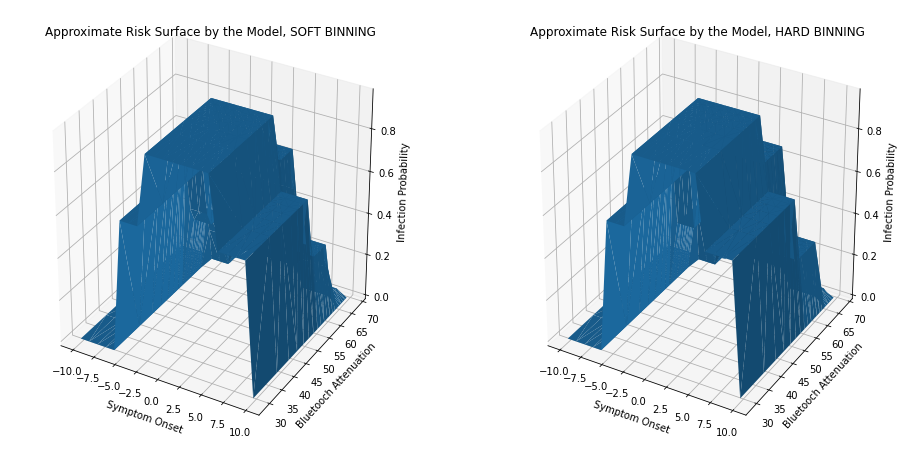

In [ ]:
soft_hard_surfaces(true_params)

## Trained on $y_{proba}$ with MSE

We first sought to test if the soft binning model can learn the parameters from training data in the simpliest case. The training data were generated using the same model with true parameters; and the model was directly learning from the risk probablility ($y_{probability}$) rather than from the labels simulated from the probability $y^{(n)}_{label} \sim Bern(y^{(n)}_{probability})$. The mean-squared-error loss function (MSE) was used. As shown below, the training minimized the training loss and recovered the risk probability surface. Interestingly, the parameters didn't converge to the true parameters.


In [ ]:
params_current, parameters_history, losses, y_preds_proba = train_model_two_steps(X, y_prob_soft, loss_fn = torch.nn.MSELoss())

Epoch 0 loss: 0.1004161462187767
Epoch 100 loss: 0.021908564493060112
Epoch 200 loss: 0.016123225912451744
Epoch 300 loss: 0.005839863792061806
Epoch 400 loss: 0.006426852196455002
Epoch 500 loss: 0.004941087681800127
Epoch 600 loss: 0.0019870689138770103
Epoch 700 loss: 0.0028774761594831944
Epoch 800 loss: 0.0059548476710915565
Epoch 900 loss: 0.00704987021163106
Epoch 1000 loss: 0.0055048344656825066
Epoch 1100 loss: 0.0036291300784796476
Epoch 1200 loss: 0.004355663899332285
Epoch 1300 loss: 0.0038940906524658203
Epoch 1400 loss: 0.004193061497062445
Epoch 1500 loss: 0.005120588466525078
Epoch 1600 loss: 0.005151547957211733
Epoch 1700 loss: 0.004299783147871494
Epoch 1800 loss: 0.0029314705170691013
Epoch 1900 loss: 0.0026907098945230246


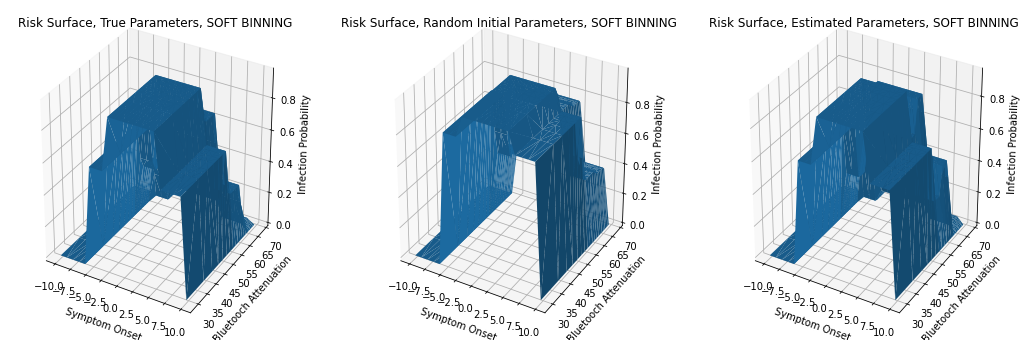

In [ ]:
risk_surfaces(true_params, parameters_history[0], parameters_history[-1], binning='soft')

In [ ]:
cmat = confusion_matrix(y_label_soft, (y_preds_proba.data > 0.5).int())
acc = accuracy_score(y_label_soft, (y_preds_proba.data > 0.5).int())
f1 = f1_score(y_label_soft, (y_preds_proba.data > 0.5).int())

print(f"For this data set, the MSE loss is {losses[-1]}")
print(f"Using the last set of parameters in trining, the accuracy is {acc}, \n the false positive rate is {FPR_rate(cmat)}, and the false negative rate is {FNR_rate(cmat)}")
print(f"The f1 score is {f1}")


For this data set, the MSE loss is 0.0023882242385298014
Using the last set of parameters in trining, the accuracy is 0.8807440476190476, 
 the false positive rate is 0.08396872419989315, and the false negative rate is 0.17510953954954261
The f1 score is 0.8426714829793082


## Trained on $y_{label}$ with BCE and MSE


We then trained the soft binning model on $y_{label}$ with either MSE or the binary-cross-entropy loss function (BCE). The model trained with $y_{label}$ and MSE was able minimize the training loss and recover the risk probability surface, while the model trained with $y_{label}$ and BCE didn't worked as well. For the BCE loss, we tried training the model with varied learning rates however, it did not work for any of these, at some point, the loss start increasing again very rapidly. We do not have a good explanation on why this is happening but we suppose that the gradient might get too big for this loss and hence the step is too big, we suppose this is why we see this big increase in loss at some point. As future work we could try different techniques to fix this optimization problem but for the moment we stook with MSE loss since it appears to perform well.

In [ ]:
params_current, parameters_history, losses, y_preds_proba = train_model_two_steps(X, y_label_soft, loss_fn = torch.nn.BCELoss())

Epoch 0 loss: 0.40959399938583374
Epoch 100 loss: 0.26671335101127625
Epoch 200 loss: 0.26240164041519165
Epoch 300 loss: 0.26235252618789673
Epoch 400 loss: 0.26195695996284485
Epoch 500 loss: 0.2616908550262451
Epoch 600 loss: 0.2596455216407776
Epoch 700 loss: 0.26034313440322876
Epoch 800 loss: 0.26003265380859375
Epoch 900 loss: 0.2600322663784027
Epoch 1000 loss: 0.25925788283348083
Epoch 1100 loss: 0.2592419683933258
Epoch 1200 loss: 0.25912120938301086
Epoch 1300 loss: 0.2594972550868988
Epoch 1400 loss: 0.25953370332717896
Epoch 1500 loss: 0.258576899766922
Epoch 1600 loss: 0.25897693634033203
Epoch 1700 loss: 0.2587295472621918
Epoch 1800 loss: 0.2592553198337555
Epoch 1900 loss: 0.2592989504337311


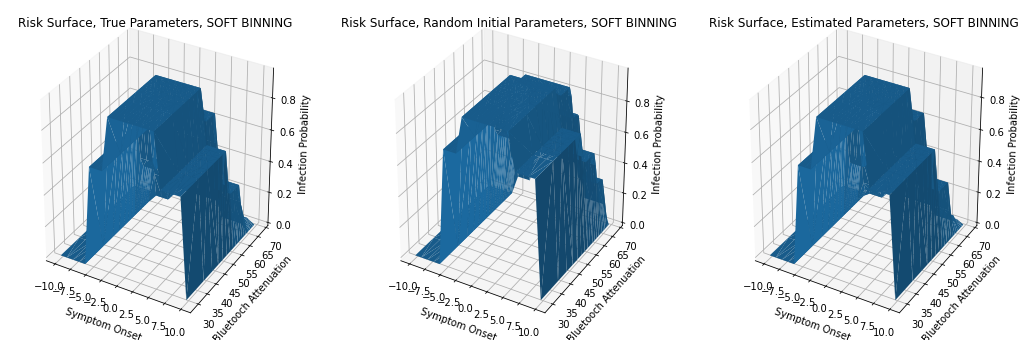

In [ ]:
risk_surfaces(true_params, parameters_history[0], parameters_history[-1], binning='soft')

In [ ]:
cmat = confusion_matrix(y_label_soft, (y_preds_proba.data > 0.5).int())
acc = accuracy_score(y_label_soft, (y_preds_proba.data > 0.5).int())
f1 = f1_score(y_label_soft, (y_preds_proba.data > 0.5).int())

print(f"For this data set, the BCE loss is {losses[-1]}")
print(f"Using the last set of parameters in trining, the accuracy is {acc}, \n the false positive rate is {FPR_rate(cmat)}, and the false negative rate is {FNR_rate(cmat)}")
print(f"The f1 score is {f1}")

For this data set, the BCE loss is 0.2588898837566376
Using the last set of parameters in trining, the accuracy is 0.8841666666666667, 
 the false positive rate is 0.09135059006362002, and the false negative rate is 0.15458528710892458
The f1 score is 0.8496600741656366


In [ ]:
params_current, parameters_history, losses, y_preds_proba = train_model_two_steps(X, y_label_soft, loss_fn = torch.nn.MSELoss())

Epoch 0 loss: 0.20587103068828583
Epoch 100 loss: 0.10549136251211166
Epoch 200 loss: 0.09884919226169586
Epoch 300 loss: 0.09743048995733261
Epoch 400 loss: 0.09508607536554337
Epoch 500 loss: 0.09281057119369507
Epoch 600 loss: 0.08650673180818558
Epoch 700 loss: 0.08389867097139359
Epoch 800 loss: 0.08713100105524063
Epoch 900 loss: 0.08734719455242157
Epoch 1000 loss: 0.08841771632432938
Epoch 1100 loss: 0.0888284295797348
Epoch 1200 loss: 0.08901217579841614
Epoch 1300 loss: 0.08832323551177979
Epoch 1400 loss: 0.0888831689953804
Epoch 1500 loss: 0.08896592259407043
Epoch 1600 loss: 0.08985968679189682
Epoch 1700 loss: 0.08985400944948196
Epoch 1800 loss: 0.09008338302373886
Epoch 1900 loss: 0.08944811671972275


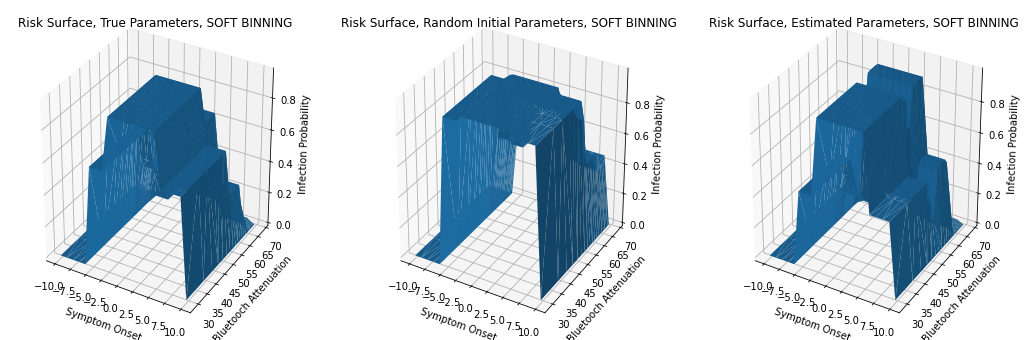

In [ ]:
risk_surfaces(true_params, parameters_history[0], parameters_history[-1], binning='soft')

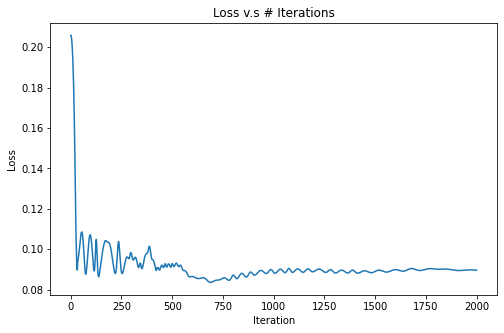

In [ ]:
plot_iter_loss(losses)

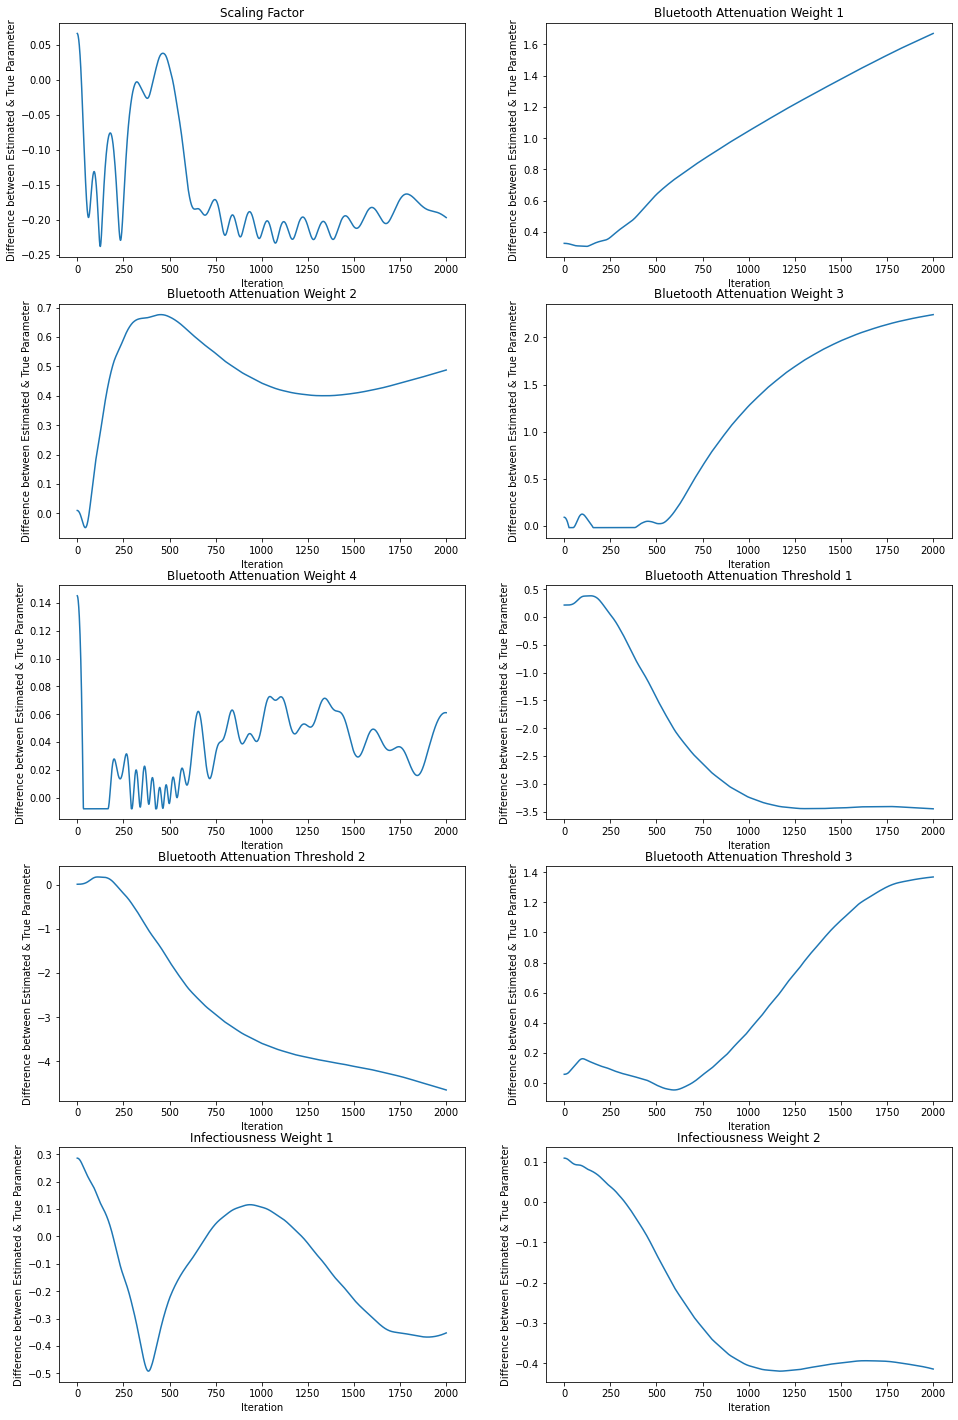

In [ ]:
plot_iter_paramdiff(parameters_history)

In [ ]:
cmat = confusion_matrix(y_label_soft, (y_preds_proba.data > 0.5).int())
acc = accuracy_score(y_label_soft, (y_preds_proba.data > 0.5).int())
f1 = f1_score(y_label_soft, (y_preds_proba.data > 0.5).int())

print(f"For this data set, the MSE loss is {losses[-1]}")
print(f"Using the last set of parameters in trining, the accuracy is {acc}, \n the false positive rate is {FPR_rate(cmat)}, and the false negative rate is {FNR_rate(cmat)}")
print(f"The f1 score is {f1}")

For this data set, the MSE loss is 0.08952352404594421
Using the last set of parameters in trining, the accuracy is 0.8776190476190476, 
 the false positive rate is 0.08688261861978534, and the false negative rate is 0.17856868321930972
The f1 score is 0.8386438549678229


## Train multiple times

Instead of training once on the randomly generated labels based on the true parameters of the soft binning model, we do "bootstrapping" to see whether or not on average gradient descent would converge to the true parameters. 

Note that based on a fixed set of parameters we choose as the true ones, the model is using the same set of risk scores and thus the same set of infection probabilities for the exposures. If a randomly generated number from standard uniform distribution is smaller than an infection probability, we give the respective exposure a label of 1, meaning positive, and 0 meaning negative otherwise.

The way we "bootstrap" is that, since the label generation is a random process, we generate labels multiple times and use them to train multiple times, and record the losses and parameters during the updates. 

In [ ]:
def train_model_boot(X, y_prob, num_boot=100, graphing=True, params_init=None, loss_fn = torch.nn.MSELoss(), num_iters=1000, lr=0.01, batch_size=300, momentum=0.9, fix_scale=False):
    
    parameters_history_allboot = []
    params_current_allboot = []
    losses_allboot = []
    y_preds_proba_allboot = []
    y_labels_boot = []

    for _ in range(num_boot):
        y = gen_label(y_prob)
        y_labels_boot.append(y.numpy())
        params_current_, parameters_history_, losses_, y_preds_proba_ = train_model_two_steps(X, y, params_init, 
                                                                                              loss_fn, num_iters, lr, 
                                                                                              batch_size, momentum, 
                                                                                              fix_scale, report=False)
        parameters_history_allboot.append(np.array(parameters_history_))
        params_current_allboot.append(params_current_.numpy())
        losses_allboot.append(losses_)
        y_preds_proba_allboot.append(y_preds_proba_.numpy())
    
    parameters_history_allboot = np.array(parameters_history_allboot)
    params_ub = np.percentile(parameters_history_allboot, 97.5, axis=0)  # 97.5 th percentile
    params_mean = np.percentile(parameters_history_allboot, 50.0, axis=0)  # mean
    params_lb = np.percentile(parameters_history_allboot, 2.5, axis=0)  # 2.5 percentile

    if graphing:
        fig, ax = plt.subplots(5, 2, figsize=(16,25))
        indices = [(i,j) for i in range(5) for j in range(2)]
        # Visualize 95% interval
        for k in range(10):
            ax[indices[k]].hlines(true_params[k], 0, num_iters, colors='black', linestyles='dashed', label='True Value')
            ax[indices[k]].plot(range(num_iters+1), params_mean[:,k], 'b-', label='Mean Value')
            ax[indices[k]].fill_between(range(num_iters+1), params_ub[:,k], params_lb[:,k], color='blue', alpha=0.2, label='95% Interval')
            ax[indices[k]].set_title(f"{param_names[k]}: 95% interval for parameter updates")
            ax[indices[k]].set_xlabel("Iteration")
            ax[indices[k]].set_ylabel("Parameter Value")
            ax[indices[k]].legend()

    return np.array(params_current_allboot), np.array(losses_allboot), np.array(y_preds_proba_allboot), np.array(y_labels_boot)



### Starting MORE RANDOMLY

We perform the experiments under three circumstances. First, this is done with initializing more randomly.

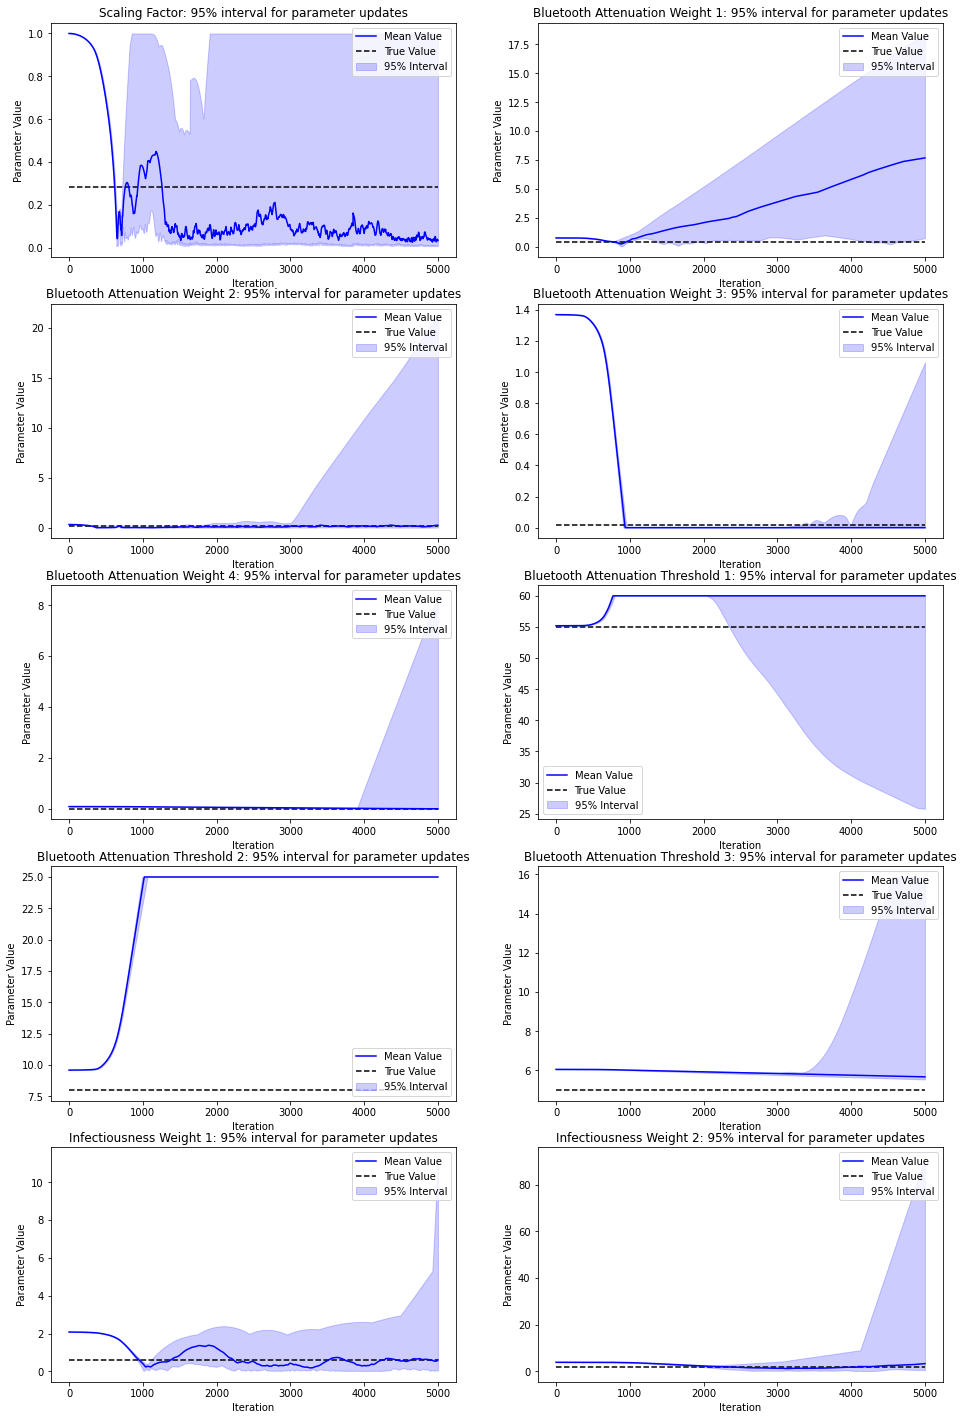

In [ ]:
random_init = torch.tensor(true_params + abs(np.random.normal(0, 1, size=10)))
project(random_init)
random_init = random_init.numpy()
params_current_allbootR, losses_allbootR, y_preds_proba_allbootR, y_labels_allbootR = train_model_boot(X, y_prob_soft, params_init=random_init, lr=0.01, num_boot=20, num_iters=5000)

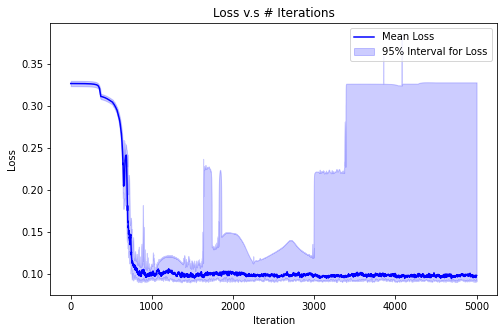

In [ ]:
plot_iter_loss_boot(losses_allbootR)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


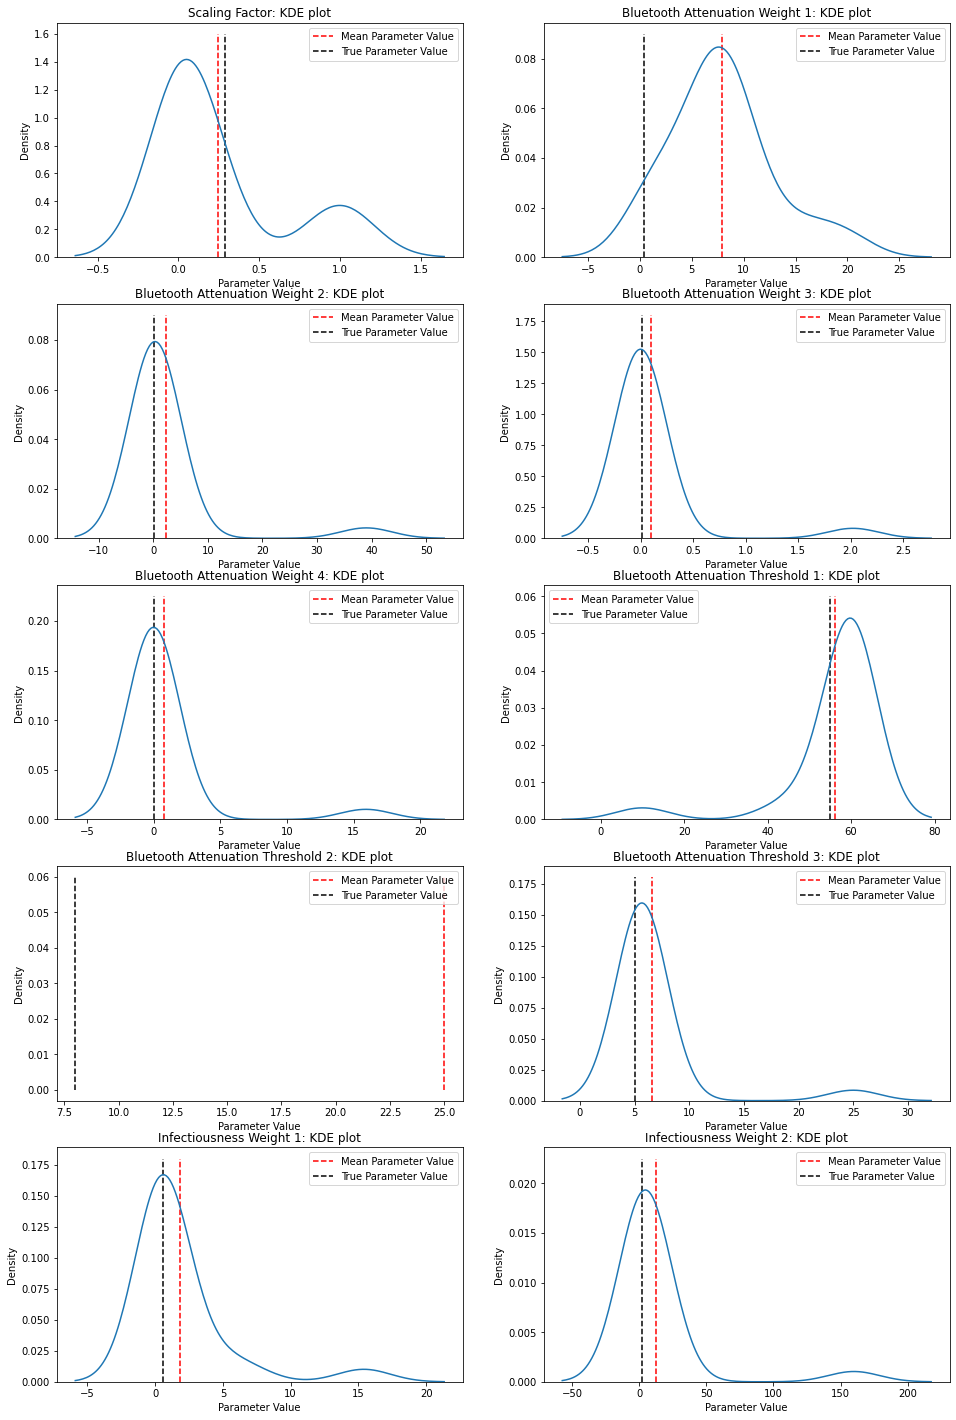

In [ ]:
plot_param_distribution(params_current_allbootR)

In [ ]:
params_current_allbootR_mean = np.mean(params_current_allbootR, axis=0)
y_preds_proba_bootR = CovidSoftModel().forward(X, params_current_allbootR_mean)

In [ ]:
accs_bootR, FPRs_bootR, FNRs_bootR = metric_boot(y_preds_proba_bootR, y_labels_allbootR, num_boot=20)

In [ ]:
print(f"For this data set, the average loss is {np.mean(losses_allbootR)}")
print(f"Using the average last set of parameters, the mean accuracy is {np.mean(accs_bootR)}, \n the mean false positive rate is {np.mean(FPRs_bootR)}, and the mean false negative rate is {np.mean(FNRs_bootR)}")

For this data set, the average loss is 0.14166881055328112
Using the average last set of parameters, the mean accuracy is 0.6724583333333334, 
 the mean false positive rate is 0.5340985345050699, and the mean false negative rate is 0.0


We observe that there the variance is very big in the loss curve. For some of the trials, it does not even converge since for some, and the loss goes up again to the original value. This is a first indicator which tells us that this optimization problem is probably very complicated. However, if we look at the parameters, we observe that even when starting from points far from the true parameters, the average over the trails does tend to converge to some close points to these true parameters. However, as for the loss curve, there is also a big variance on the convergence of the parameters. We will see later that this optimization problem has multiple solutions and it is one of the reasons why in this case they do not converge to exactly the true parameters. 

We observe a first failure mode of the model which is that when we start very far off from the true parameters, it is hard to optimize this model. However on average we see that they get relatively close to the true solution and for this reason we would recommend that when training this model, many trials with different starting points should be tried and then the average should most likely be close to the true parameters.


### Starting NEAR parameters used to create the data

Then, this is also done with initializing NEAR the true parameters.

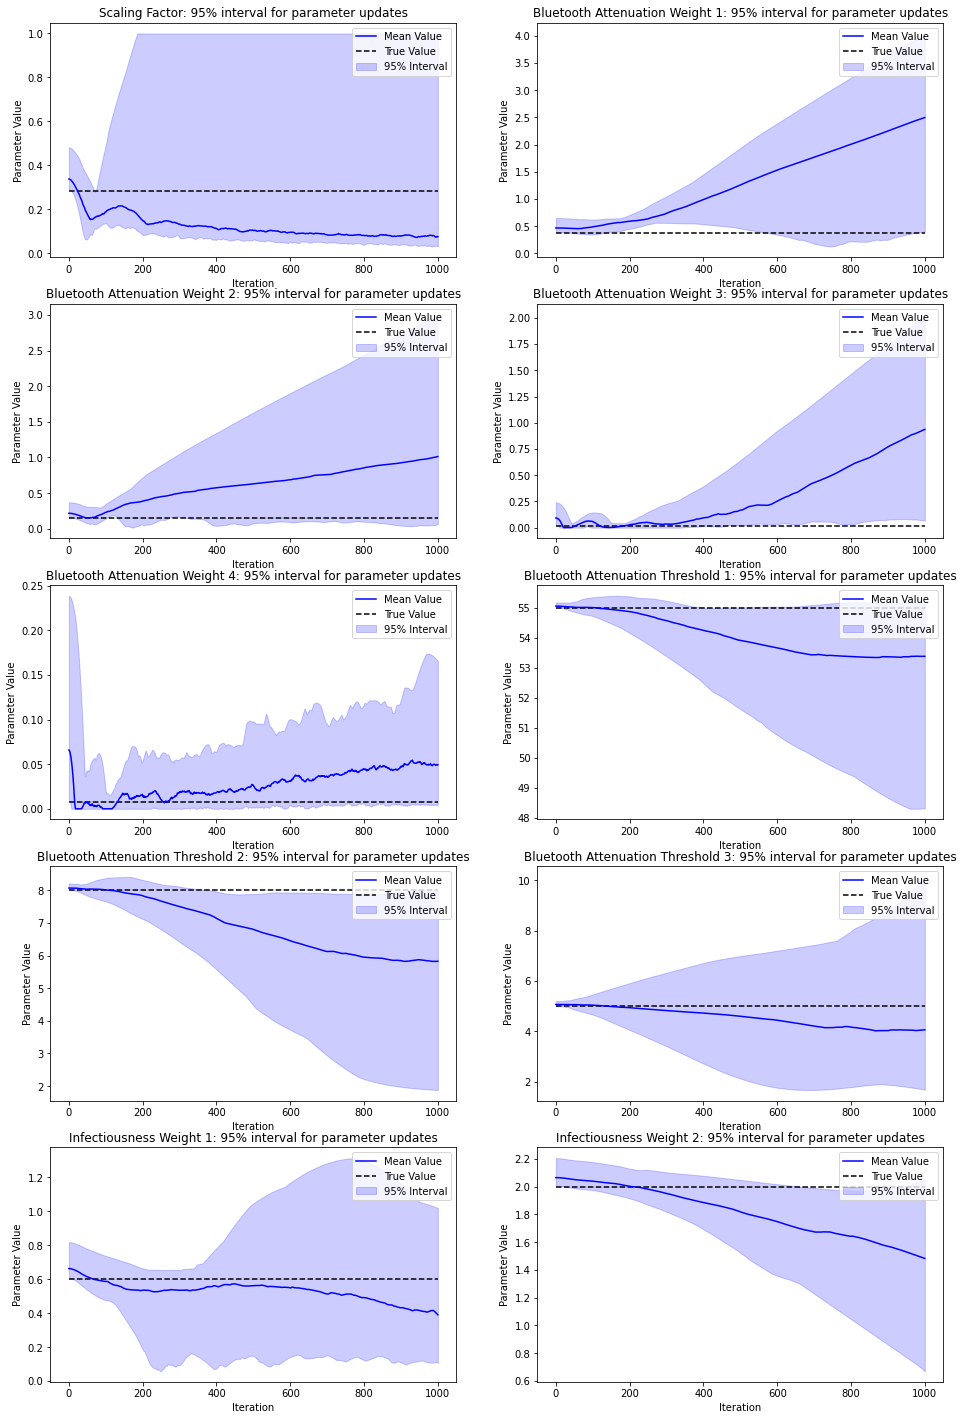

In [ ]:
params_current_allboot, losses_allboot, y_preds_proba_allboot, y_labels_allboot = train_model_boot(X, y_prob_soft)

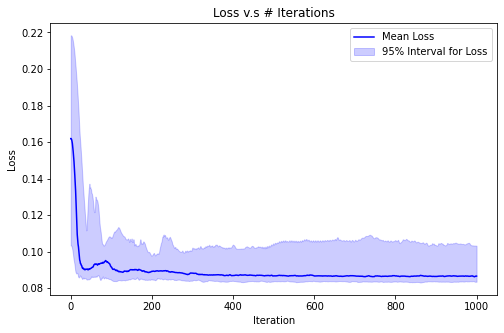

In [ ]:
plot_iter_loss_boot(losses_allboot)

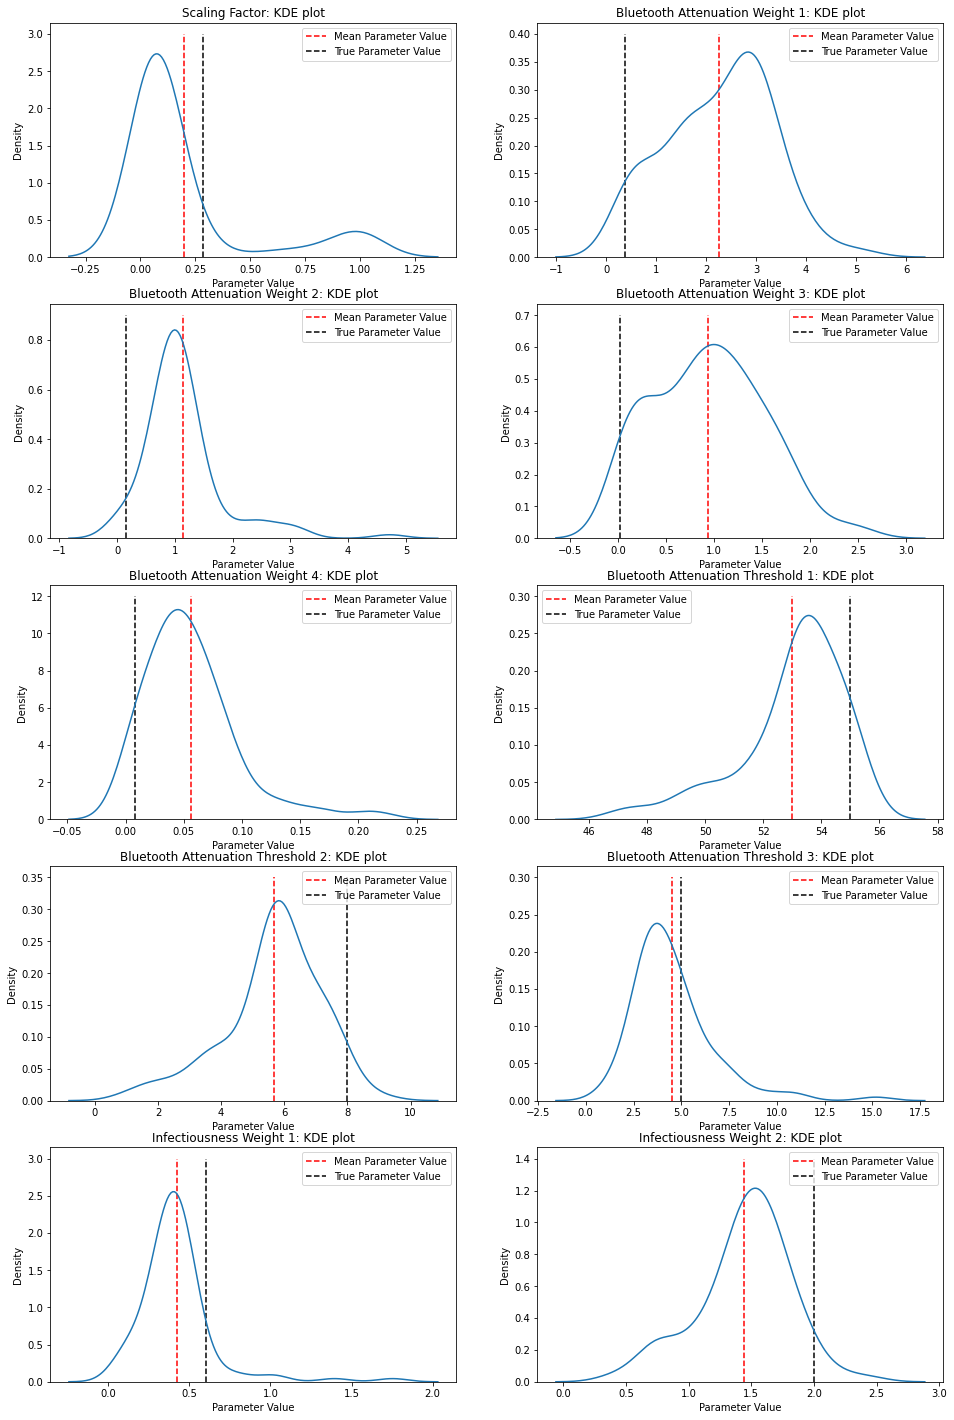

In [ ]:
plot_param_distribution(params_current_allboot)

In [ ]:
params_current_allboot_mean = np.mean(params_current_allboot, axis=0)
y_preds_proba_boot = CovidSoftModel().forward(X, params_current_allboot_mean)

In [ ]:
accs_boot, FPRs_boot, FNRs_boot = metric_boot(y_preds_proba_boot, y_labels_allboot)

In [ ]:
print(f"For this data set, the average loss is {np.mean(losses_allboot)}")
print(f"Using the average last set of parameters, the mean accuracy is {np.mean(accs_boot)}, \n the mean false positive rate is {np.mean(FPRs_boot)}, and the mean false negative rate is {np.mean(FNRs_boot)}")


For this data set, the average loss is 0.09103383652761683
Using the average last set of parameters, the mean accuracy is 0.8393943452380951, 
 the mean false positive rate is 0.2275436364164375, and the mean false negative rate is 0.054559418581667664


First of all, we see that now that we start closer to the true parameters, the variance in both the loss curve and the parameters is reduced significantly. Now, it looks like the model did converge (when we look at the loss function). However, when looking at the parameters, we see it is not always the case.

On average, the loss drops significantly after 100 iterations, with the 95% percent interval for the losses getting a bit wider with a larger number of iterations. After 1000 iterations end, it seems like the parameters have not converge, but the last updated set of parameters is not far away from the set of true parameters. However, there seems to be a trend that some of the parameters are getting farther away from the true parameters. 

Hence, we observe again this first failure mode of this model which is that we do not manage to recover exactly the true parameters.

Is this a convergence issue for gradient descent? Or is this an objective problem? It might be good to look at how the training performs on the data generated by the true parameters starting from the true parameters.

### Starting AT parameters used to create the data

Thus, the "bootstrapping" is also done initializing right AT the true parameters.  

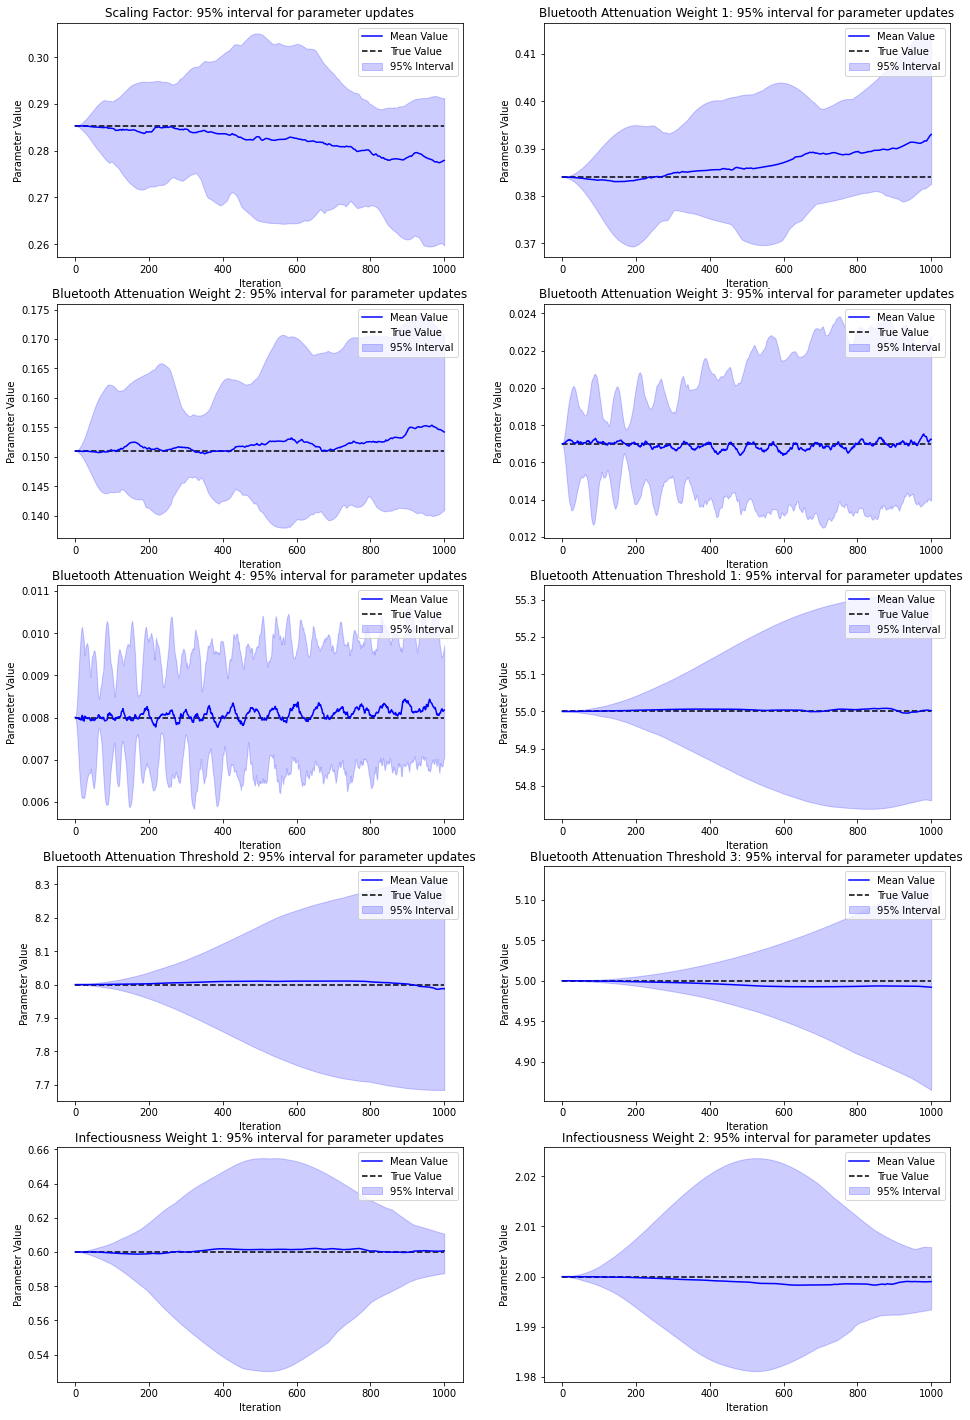

In [ ]:
params_current_allbootT, losses_allbootT, y_preds_proba_allbootT, y_labels_allbootT = train_model_boot(X, y_prob_soft, params_init=true_params)

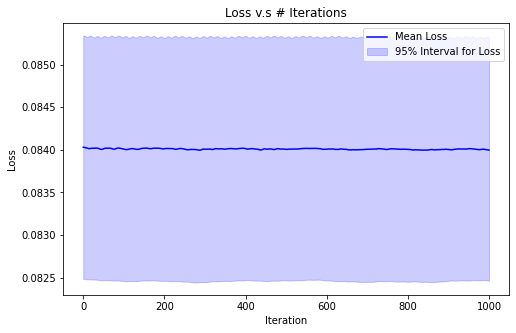

In [ ]:
plot_iter_loss_boot(losses_allbootT)

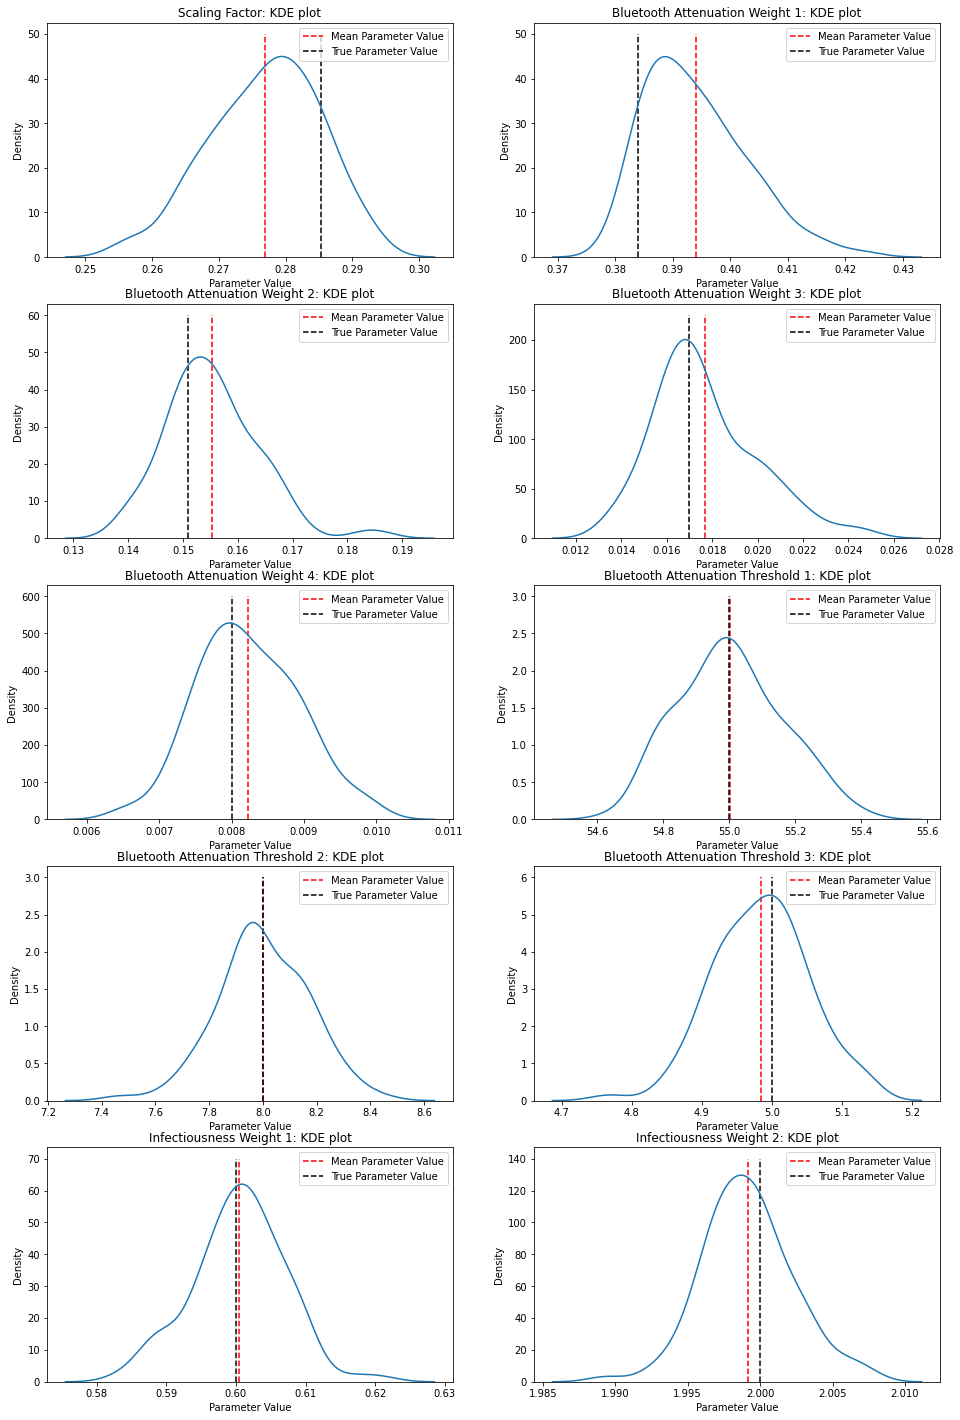

In [ ]:
plot_param_distribution(params_current_allbootT)

In [ ]:
params_current_allbootT_mean = np.mean(params_current_allbootT, axis=0)
y_preds_proba_bootT = CovidSoftModel().forward(X, params_current_allbootT_mean)

In [ ]:
accs_bootT, FPRs_bootT, FNRs_bootT = metric_boot(y_preds_proba_bootT, y_labels_allbootT)

In [ ]:
print(f"For this data set, the average loss is {np.mean(losses_allbootT)}")
print(f"Using the average last set of parameters, the mean accuracy is {np.mean(accs_bootT)}, \n the mean false positive rate is {np.mean(FPRs_bootT)}, and the mean false negative rate is {np.mean(FNRs_bootT)}")


For this data set, the average loss is 0.08402241049462801
Using the average last set of parameters, the mean accuracy is 0.8804776785714284, 
 the mean false positive rate is 0.08931414659777066, and the mean false negative rate is 0.16736662209929215


On average, the loss more or less stays at a low point across 100 trials. This loss could be a benchmark around which is the best the model can do. After 1000 iterations, most of the parameters on average end up very close to the true parameters. However, there are still some parameters ending up a bit far away from the true parameters. 

In general, the model is doing good in this case, but we suspect that the optimization problem on the 10 parameters does have many solutions, and we would explore this non-identifiability through algebra and experiments.

## Fix Scaling Factor
We sought to explore if the model could have non-identifiable solutions, such that different combinations of the parameters result in the same performance. We trained the soft binning model on the same training set with different training conditions that varies in three ways: 1. the initial value of the scaling parameter, 2. if the scaling parameter is fixed during training, and 3. what is used for y_train (Table 1). As shown in fig 1, the model, with or without fixing the scalring parameter, got to similar training loss scores after training. This suggests that there exists non-identifiable solutions. We further quantified the performance of the model using two matrics, the accuracy (fig 2) and the f1 score (fig 3) of the model prediction on the training dataset. Both fig2 and fig3 showed that the models trained with a fixed scaling parameter ([0.5, 1.2, 1.5]* true scaling paramter) performed similar to the respective ones wih the scaling parameter unfixed, on the training dataset, and that the models trained with a fixed scaling parameter ([0.1, 0.3, 1.8]* true scaling paramter) performed worse to the respective ones wih the scaling parameter unfixed. This needs to be further varified with a proper test set, either a test set generated from an independent simulator or a test set from real data.

#### Proof for existence of multiple optimal solutions
Let $\alpha$ be a constant, then

\begin{aligned}
q_n &= \text{estimated probability of infection}  \\ 
&= 1 - \exp(-\mu \cdot r_n) \\
&= 1 - \exp \left(-\mu \cdot \sum_b^4 \tau_{nb} w_b^{ble} \cdot \sum_l^3 \mathbb{I}(c_{n,l}) w_l^{con} \right) \\
&= 1 - \exp \left(-\frac{\mu}{\alpha} \cdot \sum_b^4 \tau_{nb} w_b^{ble} \cdot \sum_l^3 \mathbb{I}(c_{n,l}) (\alpha w_l^{con}) \right)
\end{aligned}

This means that the set of parameters 
$$[\mu, w_1^{ble}, w_2^{ble}, w_3^{ble}, w_4^{ble}, \theta_1^{ble}, \theta_2^{ble}, \theta_3^{ble}, w_2^{con}, w_3^{con}]$$

and the set of parameters
$$[\frac{\mu}{\alpha}, w_1^{ble}, w_2^{ble}, w_3^{ble}, w_4^{ble}, \theta_1^{ble}, \theta_2^{ble}, \theta_3^{ble}, \alpha w_2^{con}, \alpha w_3^{con}]$$

would compute the same risk given the same data. Hence, if the first set of parameters was a minima then, the second set of parameters will also be a minima.


### Table 1. training conditions

| id | Initial_scaling_param | if_fix_scaling | y_train |
| :- | :-: | :---------------: | :-: |
| true_unfix | 0.285 | no | y_proba
| true_fix | 0.285 | yes | y_proba
| unfix | 0.285 | no | y_label
| 0.1 | 0.285 * 0.1 | yes | y_label
| 0.3 | 0.285 * 0.3 | yes | y_label
| 0.5 | 0.285 * 0.5 | yes | y_label
| 1.0 | 0.285 * 1.0 | yes | y_label
| 1.2 | 0.285 * 1.2 | yes | y_label
| 1.5 | 0.285 * 1.5 | yes | y_label

In [ ]:
training_conditions = ['True_unfix','True_fix','unfix', '0.1','0.3','0.5','1.0','1.2','1.5','1.8']
experiments =[]
experiments.append([train_model_two_steps(X, y_prob_soft, num_iters=5000, fix_scale = False)])
experiments.append([train_model_two_steps(X, y_prob_soft, num_iters=5000, fix_scale = True, re_scale = 1.0)])
experiments.append([train_model_two_steps(X, y_label_soft, num_iters=5000, fix_scale = False)])

for sc in [0.1,0.3,0.5,1.0,1.2,1.5,1.8]:
    experiments.append([train_model_two_steps(X, y_label_soft, num_iters=5000, fix_scale = True, re_scale = sc)])


Epoch 0 loss: 0.061317604035139084
Epoch 100 loss: 0.006579745560884476
Epoch 200 loss: 0.0015186697710305452
Epoch 300 loss: 0.002659471705555916
Epoch 400 loss: 0.0003895086992997676
Epoch 500 loss: 0.0024591353721916676
Epoch 600 loss: 0.001746668480336666
Epoch 700 loss: 0.0021059117279946804
Epoch 800 loss: 0.0023736434523016214
Epoch 900 loss: 0.0015242659719660878
Epoch 1000 loss: 0.0005675650900229812
Epoch 1100 loss: 0.0005171598750166595
Epoch 1200 loss: 0.0012746808351948857
Epoch 1300 loss: 0.0009289886802434921
Epoch 1400 loss: 0.0014524715952575207
Epoch 1500 loss: 0.0010748776840046048
Epoch 1600 loss: 0.0011154463281854987
Epoch 1700 loss: 0.0008174655959010124
Epoch 1800 loss: 0.000883704808074981
Epoch 1900 loss: 0.001171766547486186
Epoch 2000 loss: 0.0007607158040627837
Epoch 2100 loss: 0.0010550813749432564
Epoch 2200 loss: 0.0010238070972263813
Epoch 2300 loss: 0.0012730673188343644
Epoch 2400 loss: 0.0011100196279585361
Epoch 2500 loss: 0.000985390623100102
Epoch

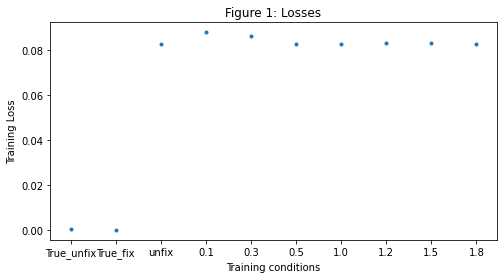

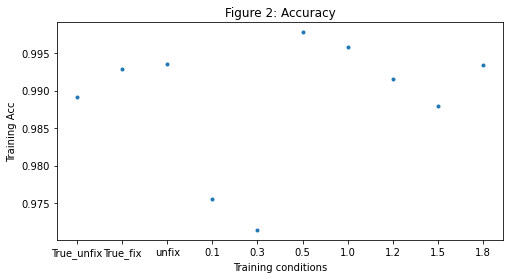

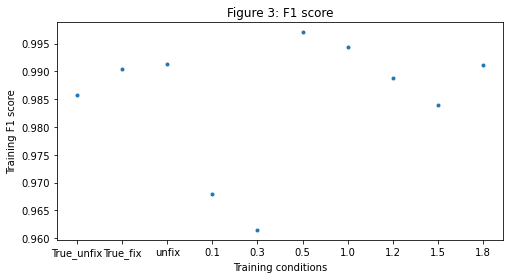

In [ ]:
results = print_results_fixscale(experiments, y_prob_soft)
results = np.array(results)

# fig1 Loss
fig,ax = plt.subplots(figsize = [8,4])

ax.set_ylabel('Training Loss')
ax.set_xlabel('Training conditions')
ax.set_title("Figure 1: Losses")
ax.plot(training_conditions,results.T[0],'.')

# fig2 Accuracy 
fig,ax = plt.subplots(figsize = [8,4])

ax.set_ylabel('Training Acc')
ax.set_xlabel('Training conditions')
ax.set_title("Figure 2: Accuracy")
ax.plot(training_conditions,results.T[1],'.')

# fig3 F1 score 
fig,ax = plt.subplots(figsize = [8,4])

ax.set_ylabel('Training F1 score')
ax.set_xlabel('Training conditions')
ax.set_title("Figure 3: F1 score")
ax.plot(training_conditions,results.T[2],'.')

#### Broader Impact for the existence of multiple solutions

We just showed that there are indeed multiple combinations of parameters that will be a minima of our loss function. This can indeed be a problem depending on how we apply our model. 

If multiple sets of parameters are optimal, they are able to give a same low loss, meaning that they can do equally well in classification by predicting the probability. In fact, some of them might even have the same shape of risk surface. 

If we only care about the performance of the model, then as long as the performance is maximal we would not really care about the parameters that we find. However, as we mentioned earlier, the upside of using this model is that it is very easily interpretable, otherwise if we just cared about performance then we could simply use a Neural Network for example. Hence, if we are want to interpret the model, having multiple minimal solutions can indeed be a problem if we are not careful since it can lead to bad conclusions. For example, if we look at the example from before where we have the following two equivalent solutions:

$$[\mu, w_1^{ble}, w_2^{ble}, w_3^{ble}, w_4^{ble}, \theta_1^{ble}, \theta_2^{ble}, \theta_3^{ble}, w_2^{con}, w_3^{con}]$$

$$[\frac{\mu}{\alpha}, w_1^{ble}, w_2^{ble}, w_3^{ble}, w_4^{ble}, \theta_1^{ble}, \theta_2^{ble}, \theta_3^{ble}, \alpha w_2^{con}, \alpha w_3^{con}]$$

Then we see that the difference between the 9th and 10th parameters in each one of the solutions are actually scaled by a factor of $\alpha$ and again if we are not careful this can make the interpreter extract bad conclusions.


Other circumstances where interpretation could be a problem when interpretation is based on absolute values of the estimated sub-risk-scores for distance and contagiouness, or relative comparison of the sub-risk-scores for distance and the sub-risk-scores for contagiousness.


# Generating the data from the "ground truth" model

In the paper, the authors design a model that simulates the ground truth on how COVID-19 spreads during interactions and it is the one used to generate the dataset. Hence, we wanted to test whether this approximate model proposed in the paper is able to properly fit this generated dataset from a different model. 

We start by implementing the ground truth model, continuing by testing its performance.

In [ ]:
# Auxiliary functions for true model
global_temperature = 5
D_min = 1
mu = -4
sigma = 1.85
alpha = 5.85
tau = 5.42
# lbda = 3.1e-6 # param in the paper
lbda = 1.1e-1 

def f_dist(d, D_min=1):
    '''
    Input:
        d - distance between people during exposure
        D_min - a constant used for truancation
    Output:
        simulated risk given distance
    '''
    return np.clip(D_min**2/d**2, a_min = None, a_max=1)

def f_inf(sigma_n, mu=-4, sigma=1.85, alpha=5.85, tau=5.42):
    '''
    Input:
        sigma_n - time since COVID symptom onset
        mu, sigma, alpha, tau - parameters for the Skewed Logistic distribution
        here, we simplify the equation by setting t_i (the incubation time) = tau
    Output:
        simulated risk probability given time since COVID symptom onset
    '''
    return infectiousness_skew_logistic(sigma_n)

def incubation_dist(t):
    mu = 1.621
    sig = 0.418
    rv = scipy.stats.lognorm(sig, scale=np.exp(mu))
    return rv.pdf(t)

# Symptom days to infectiousness
def skew_logistic_scaled(x, alpha, mu, sigma):
    return scipy.stats.genlogistic.pdf(x, alpha, loc=mu, scale=sigma)

def ptost_conditional(ts, incubation):
    mu = -4
    sigma = 1.85
    alpha = 5.85
    tau = 5.42
    fpos = skew_logistic_scaled(ts, alpha, mu, sigma)
    fneg = skew_logistic_scaled(ts*tau/incubation, alpha, mu, sigma)
    ps = fpos
    neg = np.where(ts < 0)
    ps[neg] = fneg[neg]
    ps = ps/np.max(ps)
    return ps

def ptost_uncond(tost_times):
    incub_times = np.arange(1, 14, 1)
    incub_probs = incubation_dist(incub_times) 
    tost_probs = np.zeros_like(tost_times, dtype=float)
    for k, incub in enumerate(incub_times):
        ps = ptost_conditional(tost_times, incub)
        tost_probs += incub_probs[k] * ps
    return tost_probs

infectiousness_curve_times = np.arange(-14, 14+1, 0.1)
infectiousness_curve_vals = ptost_uncond(infectiousness_curve_times)

def infectiousness_skew_logistic(delta):
    return np.interp(delta, infectiousness_curve_times, infectiousness_curve_vals)

def sn(tau_n, d_n, sigma_n):
    '''
    Input:
        tau_n - exposure duration
        d_n - distance during exposure
        sigma_n - time since COVID symptom onset
    Output:
        harzard score for exposure
    '''
    # print(f_dist(d_n, D_min).shape)
    return tau_n*f_dist(d_n, D_min)*f_inf(sigma_n, mu, sigma, alpha, tau)


def pn(x_n):
    '''
    Input:
        x_n - wrapped up (exposure duration, distance during exposure, time since COVID symptom onset)
    Output:
        infection probability given single exposure
    '''
    tau_n, d_n, sigma_n = x_n[:,[0]], x_n[:,[1]], x_n[:,[2]]
    return 1-np.exp(-lbda*sn(tau_n, d_n, sigma_n))

In [ ]:
class CovidTrueModel():
    def forward(self, x):
        # Perform forward pass and return labels
        probs = pn(x)
        print("probs", probs.shape)
        return self.gen_label(np.array(probs.reshape(-1)))

    def get_probs(self, x):
        probs = pn(x)
        return probs.reshape(-1)
        
    def gen_label(self, ys):
        p = np.random.uniform(0,1, len(ys))
        res = np.zeros(len(ys))
        res = (p < ys).astype(int)

        return res

    def get_events(self):
        return generate_exposure_events()


In [ ]:
# Generate data
ground_truth_model = CovidTrueModel()
soft_model = CovidSoftModel()

X_original = generate_exposure_events()
approx_x = torch.tensor(transform_events(X_original))

print("approx x", approx_x.shape)
true_y = torch.tensor(ground_truth_model.forward(X_original)).double()
print("y", true_y.shape)
pred_y = soft_model.forward(approx_x)
print(approx_x.shape)

print(sum(true_y))

approx x torch.Size([33600, 3])
(33600, 1)
probs (33600, 1)
y torch.Size([33600])
torch.Size([33600, 3])
tensor(5018., dtype=torch.float64)


In [ ]:
# Approximate soft model to the ground truth model
# Learn parameters

loss_fn = torch.nn.MSELoss()

global_temperature = 5
optimizer = optim.SGD(soft_model.parameters(), lr=0.001, momentum=0.9)
Y_tensor = true_y.double()
losses = []
epochs = 1000
parameters_history = [] 

for i in range(epochs):
    optimizer.zero_grad()

    output = soft_model(approx_x).double()
  
    loss = loss_fn(output, true_y)
   
    losses.append(loss.detach())
   
    curr_params = []
    for name, param in soft_model.named_parameters():
        if param.requires_grad: 
            curr_params.append(param.data)

    curr_params = torch.tensor(np.array(curr_params))
    project(curr_params)
    parameters_history.append(np.array(curr_params))
            #print(name, param.grad)
    loss.backward(retain_graph=True)

    optimizer.step()
    if i % 100 == 0:
        print("Epoch {} loss: {}".format(i, loss))

Epoch 0 loss: 0.3587166387206448
Epoch 100 loss: 0.09513456263340732
Epoch 200 loss: 0.0944245752757085
Epoch 300 loss: 0.09434686312867942
Epoch 400 loss: 0.09432515723365847
Epoch 500 loss: 0.09431549661737151
Epoch 600 loss: 0.09430897889467739
Epoch 700 loss: 0.09430348863584964
Epoch 800 loss: 0.09429845628487663
Epoch 900 loss: 0.09429370788163804


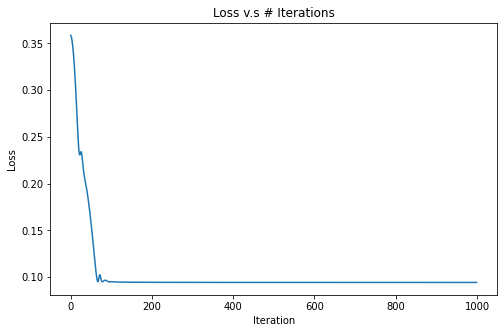

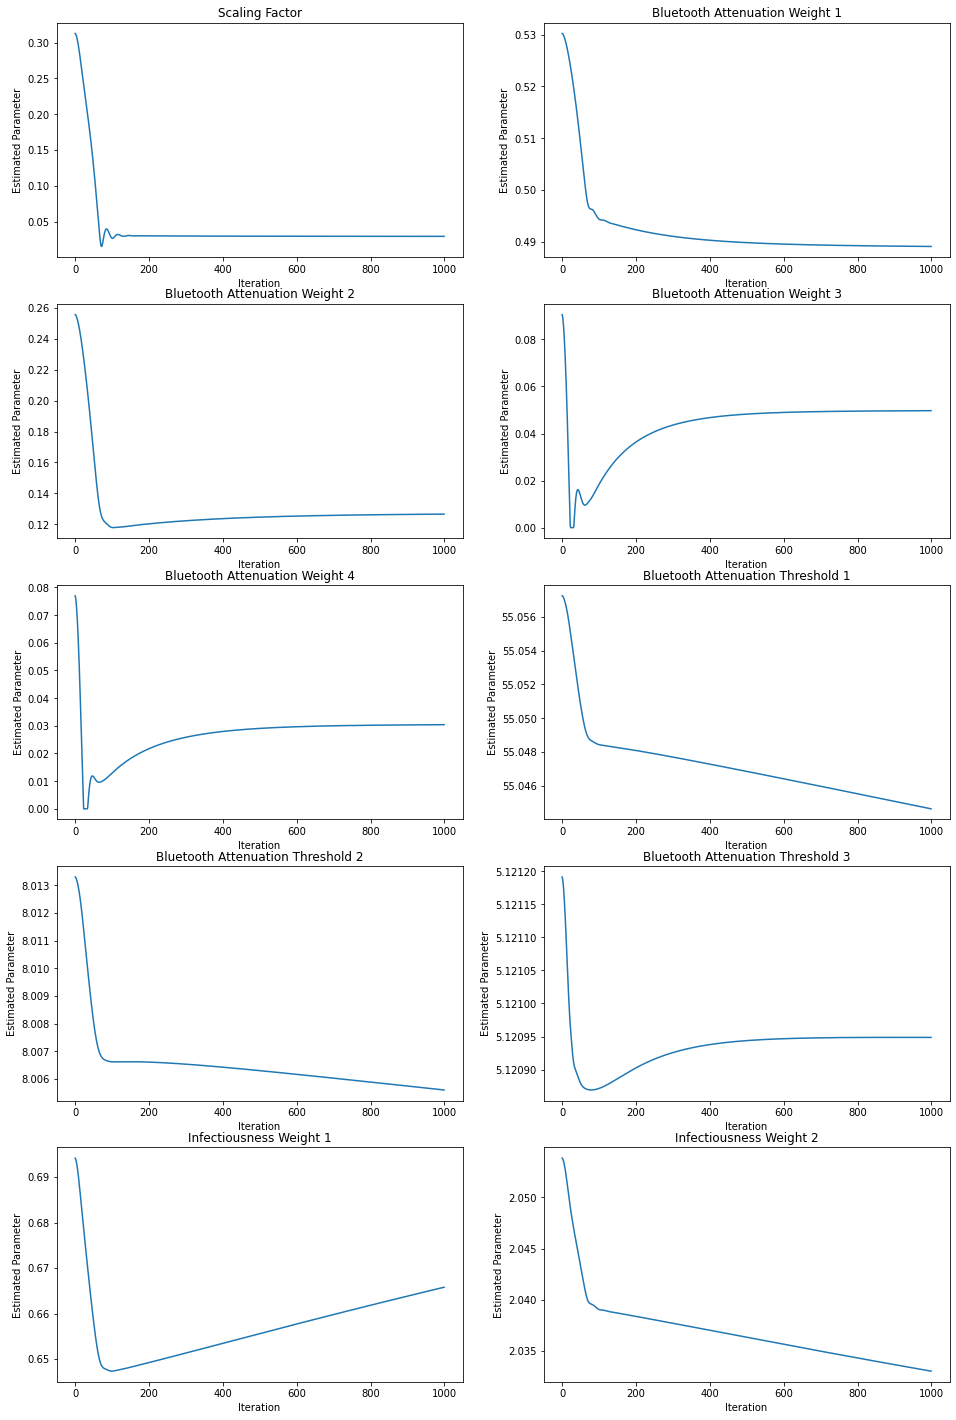

In [ ]:
plot_iter_loss(losses)
parameters_history = np.array(parameters_history)
plot_iter_param(parameters_history)


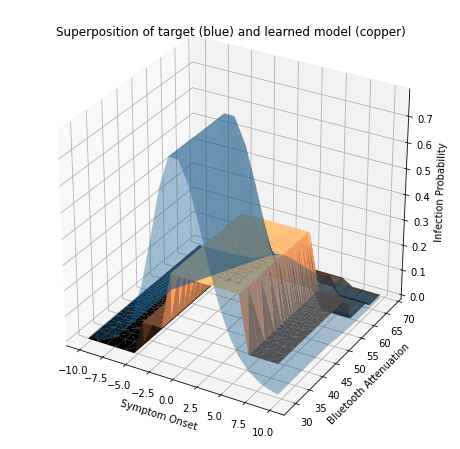

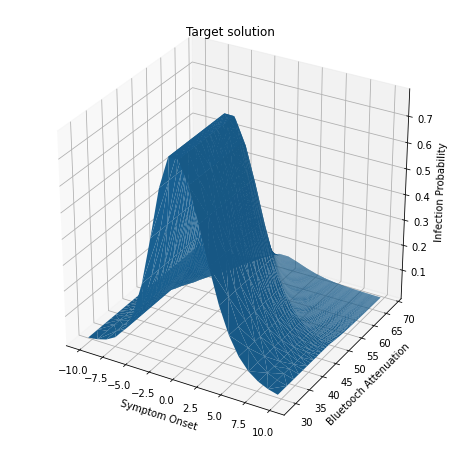

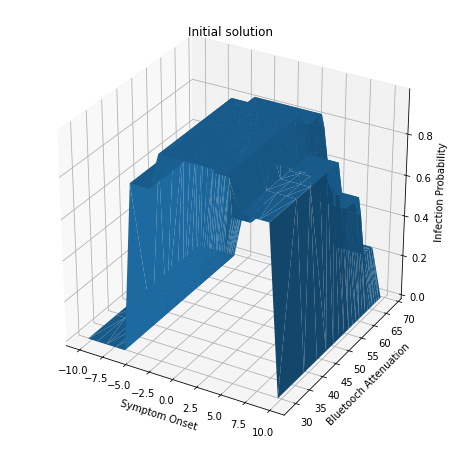

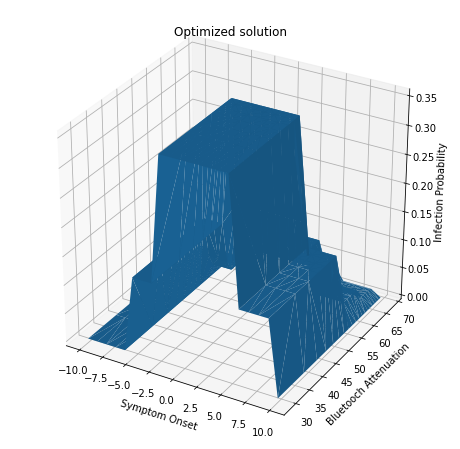

In [ ]:
plot_superposed(torch.tensor(parameters_history[-1]))
plot_comparison_with_true(parameters_history)

We observe that the shape of the trained model is far from the one we are trying to approximate. At the begginning, we thought that this could be due to an optimization problem. We tried three different things: decaying learning rate, different learning rates per each parameter and temperature annealing (we increase temperature to go from soft thresholds to hard thresholds gradually).

In [ ]:
params_current, parameters_history, losses, y_preds_proba = train_model_two_steps_and_temperature(X, true_y, num_iters=4500)


Epoch 0 loss: 0.4119018018245697
Global temperature is 0.5
Epoch 100 loss: 0.11277022957801819
Epoch 200 loss: 0.11547358334064484
Epoch 300 loss: 0.10670282691717148
Global temperature is 1
Epoch 400 loss: 0.11956608295440674
Epoch 500 loss: 0.10363823175430298
Epoch 600 loss: 0.11029428243637085
Global temperature is 1.5
Epoch 700 loss: 0.11365082859992981
Epoch 800 loss: 0.11227592080831528
Epoch 900 loss: 0.1065237745642662
Global temperature is 2
Epoch 1000 loss: 0.10602637380361557
Epoch 1100 loss: 0.10061807185411453
Epoch 1200 loss: 0.10892633348703384
Global temperature is 2.5
Epoch 1300 loss: 0.09591012448072433
Epoch 1400 loss: 0.09573360532522202
Epoch 1500 loss: 0.10580944269895554
Global temperature is 3
Epoch 1600 loss: 0.10143406689167023
Epoch 1700 loss: 0.10346614569425583
Epoch 1800 loss: 0.09697258472442627
Global temperature is 3.5
Epoch 1900 loss: 0.10504894703626633
Epoch 2000 loss: 0.09877777844667435
Epoch 2100 loss: 0.10226752609014511
Global temperature is 4


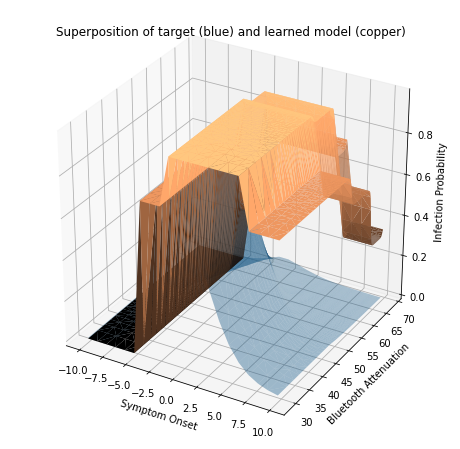

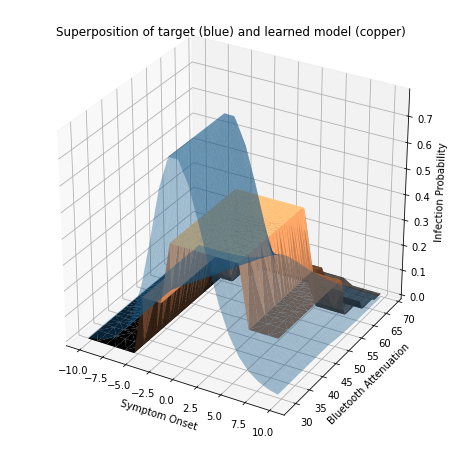

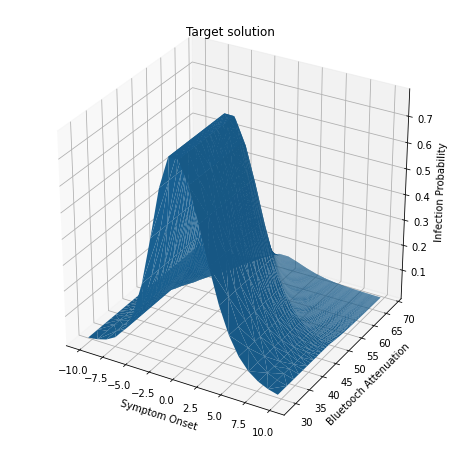

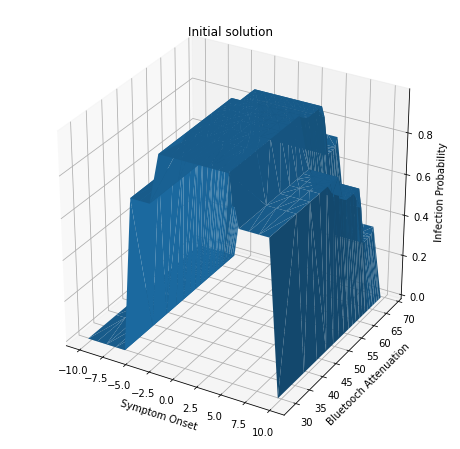

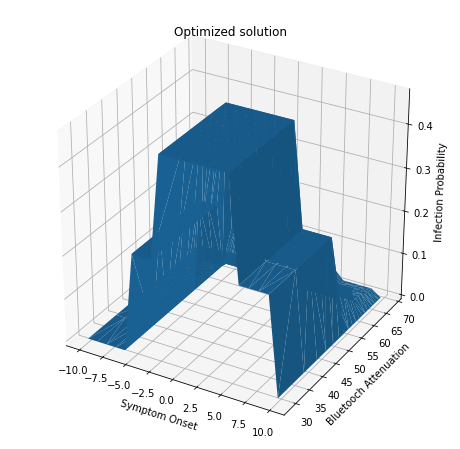

In [ ]:
plot_superposed(torch.tensor(parameters_history[0]))
plot_superposed(torch.tensor(parameters_history[-1]))
plot_comparison_with_true(parameters_history)

In [ ]:
cmatB = confusion_matrix(true_y, (y_preds_proba.data > 0.5).int())
accB = accuracy_score(true_y, (y_preds_proba.data > 0.5).int())
f1B = f1_score(true_y, (y_preds_proba.data > 0.5).int())

print(f"For this data set, the MSE loss is {losses[-1]}")
print(f"Using the last set of parameters in trining, the accuracy is {accB}, \n the false positive rate is {FPR_rate(cmatB)}, and the false negative rate is {FNR_rate(cmatB)}")
print(f"The f1 score is {f1B}")

For this data set, the MSE loss is 0.09482605755329132
Using the last set of parameters in trining, the accuracy is 0.8688392857142857, 
 the false positive rate is 0.0571338604716255, and the false negative rate is 0.552809884416102
The f1 score is 0.5045531197301856


As we observe, the resulting shape remains to be the same and has not improved. After some experimentation, we realized that the problem was not an optimization problem, we were indeed finding a minimal solution. The problem was in the symptom onset days to infectiousness level mapping. As we can see, the shape of the two models projected in the x plane, has a different mean in each one of the models. The approximate model is shifted to the right. The problem is that this mapping is fixed and is not being learned. The reason why this is not being learned is because the Google/Apple app interface only gives you certain the days since symptom onset in one of the 3 buckets for privacy concerns. However, we believe that we could still learn which is the best way to split the data into these 3 buckets and then propose to Apple/Google to use this mapping instead of their current one. This is what we are doing next.

Hence, we saw one more failure mode where because the data given to the model is not good enough (bad mapping from days since symptom onset to infectiousness level) then the model is not able to approximate with enough accuracy the target model.

# Finding the best mapping from symptom onset to infectiousness levels

In the paper, the authors give a fixed mapping from symptom onset to 3 infectiousness levels. This mapping is far from being ideal. We hypothesized that it might have been imposed by the Apple/Google app. However, we believe that we could find the best parameters and even though we will not be able to modify them later on, it would be great if these were set to the ideal parameters. For this reason, we will find the best mapping and propose it as ideal mapping.

Since these are hard thresholds, they are not differentiable and cannot be optimized using gradients. For this reason, we will use a grid search as optimization method. Furthermore, the input values of this mapping are discrete since it refers to the number of days since the symptoms appeared. Hence, the grid search will only be done on integers. To reduce the computation time, we limit the search to a small number of possibilities. If we had more computational ressources we could perform a more extensive grid search.

More concretely, we will find the best parameters by performing a grid search and for each possible combination of parameters in this grid, we will train the model for a small number of epochs (300) and take the model that returns the smallest loss in the last epoch.  

In [ ]:
ground_truth_model = CovidTrueModel()
soft_model = CovidSoftModel()

X = generate_exposure_events()

print("approx x", approx_x.shape)
true_y = torch.tensor(ground_truth_model.forward(X)).double()
print("y", true_y.shape)

print(sum(true_y))

approx x torch.Size([33600, 3])
(33600, 1)
probs (33600, 1)
y torch.Size([33600])
tensor(4878., dtype=torch.float64)


In [ ]:
def train_and_grid_search(X, y):
    param1 = range(-7,-4)
    param2 = range(-4, 1)
    param3 = range(3, 7)
    param4 = range(7, 10)

    min_loss = 100
    best_threshold = []
    best_params = []
    for t1 in param1:
      for t2 in param2:
        for t3 in param3:
          for t4 in param4:
            
            if t1< t2 and t2< t3 and t3< t4:
              thresh = [t1,t4,t2,t3]
              
              params , parameters_history, losses, y_preds_proba = train_model_with_thresholds(X, y,thresh, num_iters = 300) 
              loss = losses[-1]
              print("final loss", thresh, loss)
              if loss < min_loss:
                min_loss = loss
                best_threshold = thresh
                best_params = params

    return best_threshold, best_params

In [ ]:
best_thresh, best_params = train_and_grid_search(torch.tensor(X), true_y )

Epoch 0 loss: 0.2360339208965898
Epoch 100 loss: 0.09689225481201819
Epoch 200 loss: 0.07626778062846738
final loss [-7, 7, -4, 3] tensor(0.0761, dtype=torch.float64)
Epoch 0 loss: 0.2360357977682653
Epoch 100 loss: 0.07739117251051231
Epoch 200 loss: 0.0766911838915022
final loss [-7, 8, -4, 3] tensor(0.0767, dtype=torch.float64)
Epoch 0 loss: 0.4128712968410225
Epoch 100 loss: 0.08078965094557389
Epoch 200 loss: 0.07899067040897453
final loss [-7, 9, -4, 3] tensor(0.0782, dtype=torch.float64)
Epoch 0 loss: 0.3238870795586254
Epoch 100 loss: 0.08314022735169738
Epoch 200 loss: 0.07914778860122294
final loss [-7, 7, -4, 4] tensor(0.0780, dtype=torch.float64)
Epoch 0 loss: 0.2893001428980967
Epoch 100 loss: 0.07941835020487553
Epoch 200 loss: 0.07865399678921092
final loss [-7, 8, -4, 4] tensor(0.0786, dtype=torch.float64)
Epoch 0 loss: 0.3447787795686017
Epoch 100 loss: 0.1309872054234511
Epoch 200 loss: 0.08025606100354195
final loss [-7, 9, -4, 4] tensor(0.0793, dtype=torch.float64)


In [ ]:
print(f"The best mapping for the symptom onset days to infectiousness levels found is: {best_thresh}")

The best mapping for the symptom onset days to infectiousness levels found is: [-7, 7, -4, 3]


In [ ]:
params, parameters_history, losses, y_preds_proba = train_model_with_thresholds(torch.tensor(X), true_y, best_thresh, num_iters=2000)

Epoch 0 loss: 0.29138101753225754
Epoch 100 loss: 0.09303451435284812
Epoch 200 loss: 0.07622965301615008
Epoch 300 loss: 0.0761203120259598
Epoch 400 loss: 0.07609432501915188
Epoch 500 loss: 0.07607171738631816
Epoch 600 loss: 0.07605028109584666
Epoch 700 loss: 0.07602989473350963
Epoch 800 loss: 0.07601051694823334
Epoch 900 loss: 0.07599211002495918
Epoch 1000 loss: 0.0759746368413187
Epoch 1100 loss: 0.07595806079009429
Epoch 1200 loss: 0.0759423458259092
Epoch 1300 loss: 0.07592745651545961
Epoch 1400 loss: 0.07591335808498616
Epoch 1500 loss: 0.07590001646430511
Epoch 1600 loss: 0.07588739832717362
Epoch 1700 loss: 0.0758754711278526
Epoch 1800 loss: 0.07586420313377584
Epoch 1900 loss: 0.07585356345427101


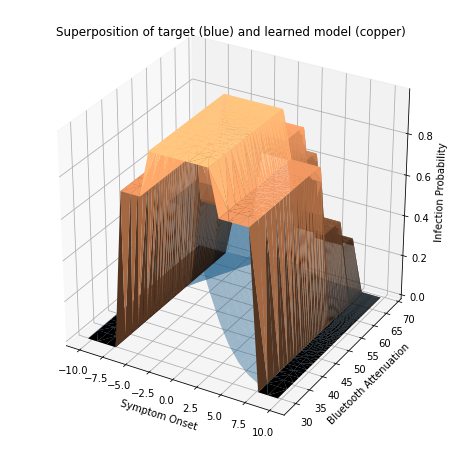

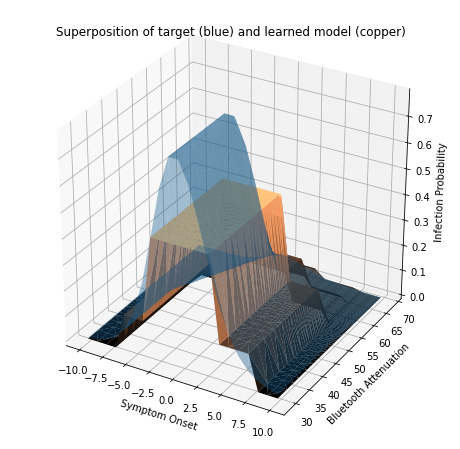

In [ ]:
plot_superposed(torch.tensor(parameters_history[0]), best_thresh)
plot_superposed(torch.tensor(parameters_history[-1]), best_thresh)


In [ ]:
cmatB = confusion_matrix(true_y, (y_preds_proba.data > 0.5).int())
accB = accuracy_score(true_y, (y_preds_proba.data > 0.5).int())
f1B = f1_score(true_y, (y_preds_proba.data > 0.5).int())

print(f"For this data set, the MSE loss is {losses[-1]}")
print(f"Using the last set of parameters in trining, the accuracy is {accB}, \n the false positive rate is {FPR_rate(cmatB)}, and the false negative rate is {FNR_rate(cmatB)}")
print(f"The f1 score is {f1B}")

For this data set, the MSE loss is 0.07584361961407987
Using the last set of parameters in trining, the accuracy is 0.8982440476190476, 
 the false positive rate is 0.022004038715966855, and the false negative rate is 0.5713407134071341
The f1 score is 0.5501907643731088


We observe in the figure above that now, the learned model using a learned mapping from symptom onset to infectiousness fits much better the previous model. Hence, we can say that we found a better mapping that the Google/Apple apps might use given that the simulator is accurate enough, which is a possible future step in this reasearch.


# Conclusion

During the current COVID-19 pandemic, digital contact tracing apps use risk score models to estimate the risks of users getting infected during exposures. The paper aims to learn the parameters for the risk score models through machine learning approach instead of relying on manually designed baseline.

In the paper, they generate a probabilistic model for disease transmission and use it to generate the simulated data, and set up the risk score model the GAEN app use to approximate and estimate infection probability. This model has 10 parameters for machine learning to optimize.

In the implementation, we started with the simplest case, not considering micro exposures or multiples exposures for users, and using the risk score model with soft binning to generate the data, i.e. the infection probabilities and infection labels for the exposure events. 

On this dataset, we first tried with training the parameters using MSE on infection probabilities. We observed that the model has high performance.

Then, we trained the parameters using BSE on the infection labels. This did not work since we observed that the loss increased after some point. For this reason we decided to stick with MSE for the rest of the experiments.

Thus, we decided to train the parameters using MSE on the infection labels. As we expected, this did a bit worse than training using MSE on infection probabilities. It still perfromed well, however, we observed that the found parameters were not the true parameters.

Then, we would like to see on average whether or not the training can recover the true parameters by training on different set of labels generated by the same set of infection probabilities multiples times. When starting more randomly, we see very big variances in both the loss and the parameters. However, most the parameters converge to a region which is close to the true parameters. When initializing near the true parameters that generate the data set, the parameters were not far away from the set of true parameters when the iterations end. However, there seemed to be a trend that some of the parameters were getting farther away from the true parameters. When initializing exactly at the true parameters, most of the parameters on average ended up very close to the true parameters. However, as some parameters seemed to get a bit far away from the true ones, we were inspired to look at the possibility of multiple solutions to the optimization problem.

Consequently, we found that the reason why we were not recovering the true parameters was because there are indeed many equivalent solutions. We gave an algebraic proof and we performed some additional experiments to show it empirically too.

Furthermore, we generated data from the true transmission model the paper presents to simulate data and observed whether the approximate model would properly fit it. We observed that it was doing very bad at the beginning and the reason could be that the mapping from days since symptom onset to contagiousness given in the paper is not optimal. Hence, we found the best mapping and retrained the model by doing grid search, this time providing a better performance.